In [ ]:
'''
전체 데이터 CV 진행하기

1. Train -> CV로 Train, Test 분리하기 
    1.1 랜덤으로 5개 idx를 분리해  cv1 ~ cv5 분리
    1.2 Mean, Median, 95Quantile 은 상관 없으나 SMOTE는 증강한 전체 데이터에 대해서 진행 -> 분위수 값이 달라지므로 범위 조절 (논문에도 수정 필요)
    1.3 각 데이터 준비
2. 모델링
    2.1 전처리 - 칼럼명 변경, Scaler 사용 (Seed 고정)
    2.2 베이지안 네트워크 -> 목적함수 : for문을 사용해 Target 값을 CV, test 평균으로 잡고 제일 잘 나오는 하이퍼 파라미터 탐색 ( 각 Train 에 대해서 R-squared 0.9 이하로 나오게 일단 설정)
    2.3 탐색 후 각 Train 값, Test 값 (RMSE, R-squared) 기록 - mean, std 기록
3. 각 항목별 최적의 모델 찾은 후
    3.1 전체 제주도 지도 예측,,,,,,,,,,,,,
    3.2 SHAP 그래프 생성


* 의문점
1.시각화 어떻게..? (Train, Test가 나뉘어져있었지만 지금은 train 과 test가 절대적이지 않아서 시각화 어떻게 해야하는지 )
2. Real-Predict 오차 값 -> 전체 데이터에 대해서 진행?
'''

# 데이터 불러오기


In [1]:
import pandas as pd
import numpy as np
##불러오기
jeju = pd.read_excel('jeju_no3.xlsx')


## 필요한 열만 갖고오기
drop_col =list(jeju.columns[6:34])+list(jeju.columns[[39,44,45]])
jeju.drop(drop_col,axis=1, inplace = True)

jeju.head()

jeju = jeju.dropna(axis=0)
## 폐기물처리, 화산회밭비, 염해논비율, 습논비율, 임지비율, 산성암비율, 하수처리장, 위생처리장, 쓰레기매립, 마을하수도, 골재채취, 염해논비율, 습논비율, 임지비율  제거
## 첫번째 열 제거

drop_cols = ['폐기물처리','화산회밭비','염해논비율',
             '습논비율','임지비율','산성암비율',
             '하수처리장','위생처리장','쓰레기매립',
             '마을하수도','골재채취']
first_jeju = jeju.drop(drop_cols, axis = 1)

first_jeju.columns

Index(['id', 'NO3-N_sum', '95Quantile', 'Count', 'mean', 'median', '시가화비율',
       '농업비율', '산림비율', '초지비율', '나지비율', '염기성암비', '퇴적암비율', '화산회비율', '보통논',
       '미숙논비율', '보통밭비율', '임지2비율', '사질밭비율', '중점밭비율', '임지3비율', '개인하수처', '인공함양정',
       '저류지', '지열이용시', '지정폐기물', '축산폐수배', '특정토양오', '폐수배출시', '평균고도', '인덱스값'],
      dtype='object')

In [5]:
jeju.corr

<bound method DataFrame.corr of       id  NO3-N_sum  95Quantile  Count       mean  median      시가화비율  \
1     13       28.0       21.95   28.0  12.321429    14.0  18.312906   
2     14      102.0       44.75  102.0   8.431373     1.0  17.015385   
3     15       79.0       20.20   79.0   6.645570     4.0  21.750742   
4     16       79.0       25.10   79.0  12.050633    10.0  15.193457   
5     17        4.0       14.00    4.0   8.500000    10.0  15.720524   
..   ...        ...         ...    ...        ...     ...        ...   
585  828       21.0        6.00   21.0   3.619048     3.0  17.081644   
590  846        6.0        4.75    6.0   2.333333     2.5  26.821773   
591  847       16.0        6.25   16.0   3.812500     4.0  31.836875   
592  848        3.0        7.50    3.0   4.333333     3.0  21.885113   
596  867       11.0        7.50   11.0   2.454545     1.0  41.620112   

          농업비율       산림비율       초지비율  ...  저류지  지열이용시  지정폐기물  축산폐수배  특정토양오  \
1    75.486662   2.739726

??lll

## 변수 영문명 변환

In [5]:
first_jeju.columns = ['id', 'NO3-N_sum', '95Quantile', 'Count', 'mean', 'median',
'Urban_Area','Agricultural_Area','Forest','Pasture','Barren','Basic Rock','Sedimentary Rock',
'Volcanic Ash','Normal Paddy','Immatured Paddy','Normal Field','Forest Land 2','Sandy Field',
'Heavy Clay Field','Forest Land 3','Private Sewage Treatment','Artificial Recharge Well',
'Detention Pond','Geothermal Facility','Specified Waste Discharge Facility','Livestock manure Discharge Facility',
'Soil contamination Facility','Wastewater Discharge Facility','Average Elevation','Neighboring Impact']

In [15]:
first_jeju[first_jeju.columns[2:]].skew()

95Quantile                             2.121290
Count                                  3.811486
mean                                   1.896887
median                                 2.212815
Urban_Area                             2.397341
Agricultural_Area                      0.048450
Forest                                 0.946543
Pasture                                1.272342
Barren                                 3.994361
Basic Rock                             1.205950
Sedimentary Rock                       5.912735
Volcanic Ash                          -1.086740
Normal Paddy                           8.766191
Immatured Paddy                        8.114156
Normal Field                           2.020242
Forest Land 2                          0.509387
Sandy Field                            4.254357
Heavy Clay Field                       3.140633
Forest Land 3                          2.404376
Private Sewage Treatment               3.114078
Artificial Recharge Well               6

## train_test split

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

## mean - test, train split

first_jeju_data = first_jeju.iloc[:,6:]
first_jeju_mean = first_jeju['mean']
x_train, x_test, y_train, y_test = train_test_split(first_jeju_data, first_jeju_mean, test_size=0.3, shuffle=True, random_state=34)


## median - test, train split

first_jeju_data = first_jeju.iloc[:,6:]
first_jeju_mean = first_jeju['median']
x_med_train, x_med_test, y_med_train, y_med_test = train_test_split(first_jeju_data, first_jeju_mean, test_size=0.3, shuffle=True, random_state=4)

## 95Quantile

jeju_95q_data= first_jeju[first_jeju['Count'] >= 25]

jeju_95q_value = jeju_95q_data['95Quantile']
jeju_95q_total = jeju_95q_data.iloc[:,6:]

x_95q_train, x_95q_test, y_95q_train, y_95q_test = train_test_split(jeju_95q_total, jeju_95q_value, test_size=0.3, shuffle=True, random_state=34)

In [9]:
x_train_id = x_train['ID']
x_test_id = x_test['ID']
x_test.drop(['ID'],axis= 1, inplace=True)
x_train.drop(['ID'],axis= 1, inplace=True)

x_med_train_id = x_med_train['ID']
x_med_test_id = x_med_test['ID']
x_med_test.drop(['ID'],axis= 1, inplace=True)
x_med_train.drop(['ID'],axis= 1, inplace=True)

x_95q_train_id = x_95q_train['ID']
x_95q_test_id = x_95q_test['ID']
x_95q_test.drop(['ID'],axis= 1, inplace=True)
x_95q_train.drop(['ID'],axis= 1, inplace=True)

In [22]:
## Train, Test, Overall R-squared + Plot Function
## 결과 시각화 그래프

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
def make_pred_obv_plot(y_test,y_train,predict_test,predict_train,title):
    from matplotlib.offsetbox import AnchoredText
    test_r2 = round(r2_score(y_test, predict_test),3)
    train_r2 =round(r2_score(y_train, predict_train),3)
    total_data = pd.concat([y_test,y_train])
    total_pred = np.concatenate([predict_test,predict_train])
    total_r2 = round(r2_score(total_data,total_pred),3)
    
    print(test_r2, 'test r-squared')
    print(train_r2, 'train r-squared')
    
    print(sqrt(mean_squared_error(y_test, predict_test)), 'test RMSE')
    print(sqrt(mean_squared_error(y_train, predict_train)), 'train RMSE')
    
    fig, ax = plt.subplots(figsize=(5,5))

    ax.scatter(y_train,predict_train,label='train',alpha=.5, marker='o', facecolor='none',edgecolors='b')
    ax.scatter(y_test,predict_test, label='test', alpha=.5, marker='s',color = 'red')    
    ## lim 설정
    lims = [np.min([ax.get_xlim(),ax.get_ylim()]), np.max([ax.get_xlim(),ax.get_ylim()])]
    ax.plot(lims,lims,zorder=0, color = 'black')
    ax.set_xlim(lims)
    ax.set_xlabel('Obv')
    ax.set_ylabel('Pred')
    ax.set_ylim(lims)
    ax.legend()
    ax.set_title(title)
    text = 'Train R-squared : ' + str(train_r2) + '\nTest R-squared : '+str(test_r2)+'\nOverall R-squared : ' +str(total_r2)
    anchored_text = AnchoredText(text,loc=4)
    ax.add_artist(anchored_text)

## smote

### 95q

In [9]:
def set_values(data):
    if data > 15.9545:
        return 'very high'
    
    elif (data <= 15.9545) & (data > 11):
        return 'high'
    
    elif (data <= 11) & (data > 7):
        return 'medium'
    
    elif (data <= 7) & (data > 5):
        return 'low'
    
    else :
        return 'very low'

first_jeju['95q_class'] = first_jeju['95Quantile'].apply(lambda data : set_values(data))
print(first_jeju['95q_class'].value_counts())

very low     237
medium        58
low           56
very high     45
high          44
Name: 95q_class, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split
smote_data = first_jeju[first_jeju['Count']>=25].loc[:,[ '95Quantile',  'Urban_Area', 'Agricultural_Area', 'Forest', 'Pasture', 'Barren',
       'Basic Rock', 'Sedimentary Rock', 'Volcanic Ash', 'Normal Paddy',
       'Immatured Paddy', 'Normal Field', 'Forest Land 2', 'Sandy Field',
       'Heavy Clay Field', 'Forest Land 3', 'Private Sewage Treatment',
       'Artificial Recharge Well', 'Detention Pond', 'Geothermal Facility',
       'Specified Waste Discharge Facility',
       'Livestock manure Discharge Facility', 'Soil contamination Facility',
       'Wastewater Discharge Facility', 'Average Elevation', 'Neighboring Impact',
       '95q_class']]
smote_class = smote_data['95q_class']
smote_total = smote_data.iloc[:,:-1]

smote_x_train, smote_x_test, smote_y_train, smote_y_test = train_test_split(smote_total, smote_class, test_size=0.3, shuffle=True, random_state=34 )

print(smote_y_train.value_counts())
x_test_smote = smote_x_test.iloc[:,1:]
y_test_smote = smote_x_test.iloc[:,0]


very low     87
medium       31
low          28
very high    28
high         24
Name: 95q_class, dtype: int64


In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train_over , y_train_over = smote.fit_resample(smote_x_train, smote_y_train)
x_train_smote = x_train_over.iloc[:,1:]
y_train_smote = x_train_over.iloc[:,0]

print(y_train_over.value_counts())

medium       87
very low     87
low          87
high         87
very high    87
Name: 95q_class, dtype: int64


## scaler

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns = x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)


In [14]:
scaler = StandardScaler()
scaler.fit(x_med_train)

x_med_train_scaled = pd.DataFrame(scaler.transform(x_med_train), columns = x_med_train.columns)
x_med_test_scaled = pd.DataFrame(scaler.transform(x_med_test), columns = x_med_test.columns)

In [15]:
scaler = StandardScaler()
scaler.fit(x_95q_train)

x_95q_train_scaled = pd.DataFrame(scaler.transform(x_95q_train), columns = x_95q_train.columns)
x_95q_test_scaled = pd.DataFrame(scaler.transform(x_95q_test), columns = x_95q_test.columns)

In [16]:
scaler = StandardScaler()
scaler.fit(x_train_smote)

x_95q_train_scaled_smote = pd.DataFrame(scaler.transform(x_train_smote), columns = x_train_smote.columns)
x_95q_test_scaled_smote = pd.DataFrame(scaler.transform(x_test_smote), columns = x_test_smote.columns)

# 패키지 목록

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# RF

## mean

0.559 test r-squared
0.796 train r-squared
1.9057526903933792 test RMSE
1.5444854778168795 train RMSE


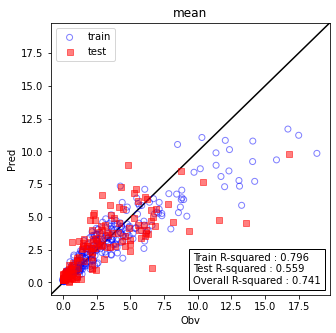

In [75]:
model = RandomForestRegressor(n_estimators = 50, max_depth =8, min_samples_split = 10)
model.fit(x_train,np.log1p(y_train).values.ravel())
rf_predict = model.predict(x_test)
train_predict = model.predict(x_train)

make_pred_obv_plot(y_test,y_train,np.expm1(rf_predict),np.expm1(train_predict),'mean')

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import numpy as np

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.5496   |  7.336    |  15.53    |  50.03    |
|  2        |  0.5388   |  6.419    |  6.348    |  73.08    |
|  3        |  0.5375   |  5.49     |  9.529    |  149.2    |
|  4        |  0.561    |  8.311    |  10.71    |  221.3    |
|  5        |  0.5345   |  5.636    |  18.05    |  56.85    |
|  6        |  0.561    |  8.456    |  10.18    |  221.8    |
|  7        |  0.545    |  9.879    |  18.99    |  230.5    |
|  8        |  0.5622   |  8.619    |  4.323    |  214.5    |
|  9        |  0.5572   |  11.85    |  13.55    |  201.1    |
|  10       |  0.5296   |  4.2      |  4.063    |  187.5    |
|  11       |  0.5265   |  4.961    |  19.5     |  209.0    |
|  12       |  0.5311   |  4.396    |  4.452    |  219.5    |
|  13       |  0.5634   |  10.15    |  7.108    |  216.1    |
|  14       |  0.5656   |  11.14    |  6.88     |  211.4    |
|  15   

|  80       |  0.5536   |  11.96    |  12.01    |  103.2    |
|  81       |  0.5597   |  11.76    |  10.13    |  171.7    |
|  82       |  0.5562   |  11.94    |  12.4     |  183.8    |
|  83       |  0.5262   |  4.046    |  6.234    |  50.15    |
|  84       |  0.5584   |  11.96    |  4.092    |  126.2    |
|  85       |  0.5406   |  11.79    |  19.54    |  51.6     |
|  86       |  0.5584   |  11.96    |  4.48     |  63.7     |
|  87       |  0.5638   |  11.89    |  9.619    |  279.3    |
|  88       |  0.5289   |  4.42     |  19.78    |  241.9    |
|  89       |  0.5559   |  11.8     |  12.06    |  143.9    |
|  90       |  0.565    |  11.99    |  10.42    |  56.27    |
|  91       |  0.5539   |  11.95    |  4.805    |  146.6    |
|  92       |  0.5196   |  4.343    |  12.01    |  85.21    |
|  93       |  0.5564   |  11.64    |  4.148    |  102.6    |
|  94       |  0.5534   |  11.88    |  15.79    |  126.0    |
|  95       |  0.5611   |  11.77    |  10.65    |  65.95    |
|  96   

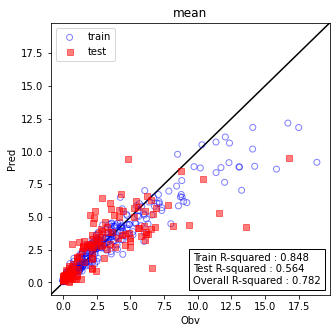

In [76]:
from sklearn.metrics import r2_score, mean_squared_error
def RF_cv(n_estimators, max_depth,# min_samples_leaf,
          min_samples_split):
          #silent=True, nthread=-1
        

      # 모델 정의
    model = RandomForestRegressor(n_estimators = int(n_estimators),
                                  max_depth = int(max_depth),
 #                                 min_samples_leaf = int(min_samples_leaf),
                                  min_samples_split = int(min_samples_split), random_state = 42)


    model.fit(x_train, np.log1p(y_train).values.ravel())

      # 예측값 출력
    y_pred= model.predict(x_test)
    r2 = r2_score(y_test, np.expm1(y_pred))
    return r2
    ## return 값을 바탕으로 베이지안 네트워크 최적화 진행


from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'n_estimators' : (50, 300),
           'max_depth' : (4,12),
#            'min_samples_leaf' : (6,15),
           'min_samples_split' : (4, 20)
          }

bo=BayesianOptimization(f=RF_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=5, n_iter=100, acq='ei', xi=0.02)

print(bo.max)

model = RandomForestRegressor(n_estimators = int(bo.max['params']['n_estimators']), max_depth =int(bo.max['params']['max_depth']), min_samples_split = int(bo.max['params']['min_samples_split']))
score = cross_val_score(model, x_train, np.log1p(y_train).values.ravel(), cv = 5,scoring='r2')
cv_score = score.mean()
model.fit(x_train,np.log1p(y_train).values.ravel())
rf_predict = model.predict(x_test)
train_predict = model.predict(x_train)

make_pred_obv_plot(y_test,y_train,np.expm1(rf_predict),np.expm1(train_predict),'mean')

0.481 test r-squared
0.865 train r-squared
2.068277698363145 test RMSE
1.2575937909607917 train RMSE


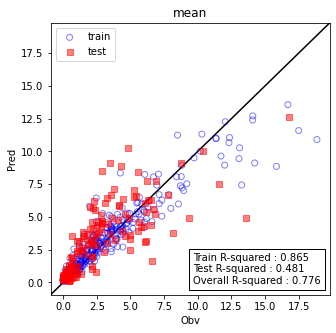

In [22]:
# model = RandomForestRegressor(n_estimators = int(bo.max['params']['n_estimators']), max_depth =int(bo.max['params']['max_depth']), min_samples_split = int(bo.max['params']['min_samples_split']))
mean_rf = RandomForestRegressor(n_estimators = 27, max_depth =11, min_samples_split = 6)
# score = cross_val_score(model, x_train, y_train.values.ravel(), cv = 5,scoring='r2')
# cv_score = score.mean()
# print(score, 'score')
# print(cv_score, 'mean score')
# score = cross_val_score(model, x_train, y_train.values.ravel(), cv = 5,scoring='neg_mean_squared_error')
# cv_score = score.mean()
# print(np.sqrt(-1 * score), 'score')
# print(np.sqrt(-1 * cv_score), 'mean score')
mean_rf.fit(x_train,y_train.values.ravel())
rf_predict = mean_rf.predict(x_test)
train_predict = mean_rf.predict(x_train)

make_pred_obv_plot(y_test,y_train,rf_predict,train_predict,'mean')


In [28]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)

error_put(mean_rf,x_train,x_test,y_train,y_test, mean_error_train,mean_error_test, mean_error_total, 'RF')

In [31]:
mean_error_test

id        RF
495  687  1.339275
92   177  0.674658
315  466  2.112814
388  553 -0.495854
309  456  0.419143
..   ...       ...
209  333  4.598321
537  746  1.924627
493  685  0.769162
366  527  2.833403
467  654 -0.677553

[132 rows x 2 columns]

### smote

In [110]:
from sklearn.metrics import r2_score, mean_squared_error
def RF_cv(n_estimators, max_depth,# min_samples_leaf,
          min_samples_split):
          #silent=True, nthread=-1
        

      # 모델 정의
    model = RandomForestRegressor(n_estimators = int(n_estimators),
                                  max_depth = int(max_depth),
 #                                 min_samples_leaf = int(min_samples_leaf),
                                  min_samples_split = int(min_samples_split), random_state = 42)
#     scores = cross_val_score(model, x_train,y_train.values.ravel(),cv=3, scoring = 'r2')
#     total_score = scores.mean()
    
#     return total_score

    
    # 모델 훈련
    model.fit(x_train_smote, y_train_smote.values.ravel())

      # 예측값 출력
    y_pred= np.expm1(model.predict(x_test))
    r2 = r2_score(np.expm1(y_test), y_pred)
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'n_estimators' : (50, 500),
           'max_depth' : (8,  12),
#            'min_samples_leaf' : (6,15),
           'min_samples_split' : (4, 20)
          }

bo=BayesianOptimization(f=RF_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=10, n_iter=100, acq='ei', xi=0.01)

bo.max

model = RandomForestRegressor(n_estimators = int(bo.max['params']['n_estimators']), max_depth =int(bo.max['params']['max_depth']), min_samples_split = int(bo.max['params']['min_samples_split']))
model.fit(x_train,y_train.values.ravel())
rf_predict = np.expm1(model.predict(x_test))
train_predict = np.expm1(model.predict(x_train))

make_pred_obv_plot(np.expm1(y_test),np.expm1(y_train),rf_predict,train_predict,'mean')

Urban_Area  Agricultural_Area     Forest    Pasture    Barren  \
532    0.880373          23.045054   6.706370  65.095805  4.272398   
361   12.099738          77.375328   8.792651   1.496063  0.236220   
443    3.585347           1.506885  35.983372  57.313588  1.610808   
259   57.034519          32.975941   4.759414   4.864017  0.366109   
448   43.714746          54.754230   0.000000   0.443191  1.087832   
..          ...                ...        ...        ...       ...   
93     5.437597          38.037286  21.646815  34.878301  0.000000   
330   16.447167          37.519142  39.234303   6.339969  0.459418   
487    1.295001          25.977726  45.428645  26.288526  1.010101   
131   31.304348          40.676328  17.294686   9.468599  1.256039   
559    2.485759          55.230451  14.215432  26.929052  1.139306   

     Basic Rock  Sedimentary Rock  Volcanic Ash  Normal Paddy  \
532    0.000000           0.00000    100.000000      0.000000   
361    1.417234           0.00000     98.582766      0.000000   
443    0.000000           0.00000    100.000000      0.000000   
259   50.880373           0.00000     49.119627      0.000000   
448   92.147708           0.00000      7.852292      0.000000   
..          ...               ...           ...           ...   
93     0.000000           0.00000    100.000000      0.000000   
330   73.313590           0.00000     24.218493      0.000000   
487    4.105649           0.00000     95.894351      0.000000   
131   55.287009          23.26284     21.450151      3.726083   
559    0.751101           0.00000     99.248899      0.000000   

     Immatured Paddy  ...  Private Sewage Treatment  Artificial Recharge Well  \
532         0.000000  ...                         0                         0   
361         0.000000  ...                         7                         2   
443         0.000000  ...                         0                         0   
259         0.000000  ...                        13                         0   
448         0.000000  ...                        46                         2   
..               ...  ...                       ...                       ...   
93          0.000000  ...                         6                         0   
330         0.000000  ...                         0                         0   
487         0.000000  ...                         3                         0   
131         7.653575  ...                        21                         0   
559         0.000000  ...                         2                         0   

     Detention Pond  Geothermal Facility  Specified Waste Discharge Facility  \
532               0                    0                                   0   
361               0                    3                                   0   
443               0                    0                                   0   
259               0                    0                                   7   
448               0                    1                                   3   
..              ...                  ...                                 ...   
93                0                    2                                   0   
330               1                   14                                   6   
487               0                    0                                   0   
131               0                    0                                   0   
559               0                    0                                   0   

     Livestock manure Discharge Facility  Soil contamination Facility  \
532                                    0                            0   
361                                    0                            0   
443                                    2                            0   
259                                    0                            4   
448                                    0                            2   
..         

0.542 test r-squared
0.93 train r-squared
1.9428078198146366 test RMSE
0.9057782155105805 train RMSE


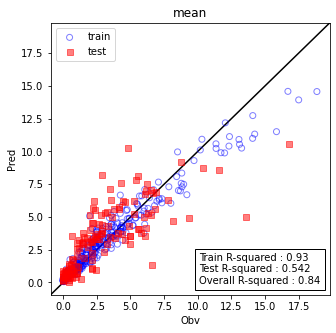

In [42]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
model = RandomForestRegressor(n_estimators = 100)
model.fit(x_train,y_train.values.ravel())
rf_predict = model.predict(x_test)
train_predict = model.predict(x_train)

make_pred_obv_plot(y_test,y_train,rf_predict,train_predict,'mean')

## Median

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.4685   |  6.502    |  6.322    |  100.0    |
|  2        |  0.4813   |  5.814    |  2.881    |  104.6    |
|  3        |  0.4702   |  5.118    |  4.073    |  119.8    |
|  4        |  0.2      |  7.233    |  4.515    |  134.3    |
|  5        |  0.4602   |  5.227    |  7.269    |  101.4    |
|  6        |  0.2      |  8.023    |  4.504    |  127.9    |
|  7        |  0.4478   |  4.842    |  3.189    |  140.0    |
|  8        |  0.2      |  9.81     |  3.881    |  134.6    |
|  9        |  0.4688   |  9.258    |  7.368    |  104.3    |
|  10       |  0.4471   |  4.234    |  3.019    |  143.9    |
|  11       |  0.4508   |  4.206    |  3.533    |  113.5    |
|  12       |  0.4675   |  10.0     |  8.0      |  114.9    |
|  13       |  0.2      |  10.0     |  2.0      |  109.7    |
|  14       |  0.4381   |  4.428    |  8.0      |  116.4    |
|  15   

|  81       |  0.4951   |  6.226    |  2.164    |  113.3    |
|  82       |  0.471    |  5.982    |  3.329    |  111.7    |
|  83       |  0.2      |  8.041    |  2.022    |  114.5    |
|  84       |  0.4808   |  5.58     |  2.142    |  112.7    |
|  85       |  0.4359   |  4.0      |  8.0      |  100.0    |
|  86       |  0.4411   |  4.0      |  4.593    |  129.9    |
|  87       |  0.4694   |  8.636    |  7.974    |  123.1    |
|  88       |  0.4685   |  7.091    |  7.948    |  124.3    |
|  89       |  0.4744   |  6.491    |  7.678    |  121.6    |
|  90       |  0.4804   |  6.1      |  5.232    |  122.7    |
|  91       |  0.4706   |  10.0     |  8.0      |  125.1    |
|  92       |  0.4731   |  5.546    |  3.555    |  102.6    |
|  93       |  0.4727   |  5.952    |  3.711    |  113.3    |
|  94       |  0.4402   |  4.0      |  5.208    |  137.7    |
|  95       |  0.4606   |  8.215    |  8.0      |  100.0    |
|  96       |  0.4383   |  4.0      |  5.438    |  144.9    |
|  97   

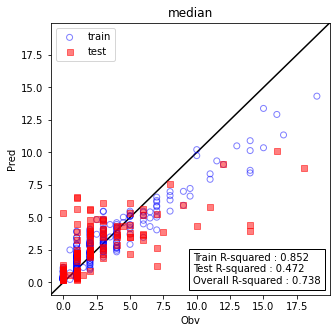

In [179]:
from sklearn.metrics import r2_score, mean_squared_error
def RF_cv(n_estimators, max_depth,# min_samples_leaf,
          min_samples_split):
          #silent=True, nthread=-1
        

      # 모델 정의
    model = RandomForestRegressor(n_estimators = int(n_estimators),
                                  max_depth = int(max_depth),
 #                                 min_samples_leaf = int(min_samples_leaf),
                                  min_samples_split = int(min_samples_split), random_state = 42)
#     scores = cross_val_score(model, x_train,y_train.values.ravel(),cv=3, scoring = 'r2')
#     total_score = scores.mean()
    
#     return total_score

    
    # 모델 훈련
    model.fit(x_med_train, y_med_train.values.ravel())

      # 예측값 출력
    y_pred= model.predict(x_med_test)
    r2 = r2_score(y_med_test, y_pred)
    train_pred = model.predict(x_med_train)
    
    r2_train = r2_score(y_med_train,train_pred)
    
    if r2_train > 0.86:
        r2 = 0.2
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'n_estimators' : (100, 150),
           'max_depth' : (4,10),
#            'min_samples_leaf' : (6,15),
           'min_samples_split' : (2, 8)
          }

bo=BayesianOptimization(f=RF_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=10, n_iter=100, acq='ei', xi=0.03)

print(bo.max)

model = RandomForestRegressor(n_estimators = int(bo.max['params']['n_estimators']), max_depth =int(bo.max['params']['max_depth']), min_samples_split = int(bo.max['params']['min_samples_split']))
score = cross_val_score(model, x_med_train, y_med_train.values.ravel(), cv = 5,scoring='r2')
cv_score = score.mean()
print(score)
print(cv_score)

model.fit(x_med_train,y_med_train.values.ravel())
rf_predict = model.predict(x_med_test)
train_predict = model.predict(x_med_train)

make_pred_obv_plot(y_med_test,y_med_train,rf_predict,train_predict,'median')

In [32]:
med_rf = RandomForestRegressor(n_estimators = 121, max_depth =6, min_samples_split = 3)


med_rf.fit(x_med_train,y_med_train.values.ravel())



RandomForestRegressor(max_depth=6, min_samples_split=3, n_estimators=121)

In [33]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)

error_put(med_rf,x_med_train,x_med_test,y_med_train,y_med_test, med_error_train,med_error_test, med_error_total, 'RF')

In [36]:
med_error_train

id        RF
65   140 -2.913799
13    53 -4.755629
456  638 -0.628047
482  674  1.831857
417  590 -0.695249
..   ...       ...
485  677  0.284691
520  723 -0.024703
244  381  1.536389
206  330  0.177569
131  229  3.154153

[308 rows x 2 columns]

## 95q

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.5697   |  7.668    |  15.53    |  50.03    |
|  2        |  0.2974   |  7.209    |  6.348    |  73.08    |
|  3        |  0.5735   |  6.745    |  9.529    |  149.2    |
|  4        |  0.5695   |  8.155    |  10.71    |  221.3    |
|  5        |  0.5593   |  6.818    |  18.05    |  56.85    |
|  6        |  0.5817   |  7.262    |  8.773    |  148.6    |
|  7        |  0.2864   |  10.0     |  4.0      |  138.0    |
|  8        |  0.2846   |  9.874    |  5.707    |  152.6    |
|  9        |  0.5731   |  6.219    |  9.953    |  146.5    |
|  10       |  0.5565   |  7.952    |  19.13    |  52.48    |
|  11       |  0.575    |  9.75     |  14.19    |  54.29    |
|  12       |  0.5797   |  6.0      |  12.71    |  53.84    |
|  13       |  0.575    |  9.284    |  9.248    |  50.04    |
|  14       |  0.2858   |  9.169    |  7.404    |  55.55    |
|  15   

|  81       |  0.5717   |  9.812    |  12.63    |  169.2    |
|  82       |  0.5691   |  6.014    |  11.68    |  171.2    |
|  83       |  0.5793   |  7.903    |  8.439    |  168.2    |
|  84       |  0.5747   |  9.855    |  8.337    |  172.7    |
|  85       |  0.2771   |  6.067    |  5.059    |  172.0    |
|  86       |  0.5713   |  10.0     |  11.27    |  173.1    |
|  87       |  0.5762   |  9.316    |  9.375    |  165.7    |
|  88       |  0.5723   |  9.509    |  10.19    |  169.7    |
|  89       |  0.5706   |  6.717    |  10.4     |  166.6    |
|  90       |  0.5624   |  6.644    |  16.25    |  173.2    |
|  91       |  0.5733   |  10.0     |  11.34    |  179.1    |
|  92       |  0.5662   |  7.561    |  16.11    |  180.0    |
|  93       |  0.5696   |  10.0     |  13.1     |  184.2    |
|  94       |  0.5702   |  6.214    |  11.68    |  182.0    |
|  95       |  0.5657   |  6.158    |  15.69    |  186.5    |
|  96       |  0.5744   |  7.597    |  9.206    |  187.1    |
|  97   

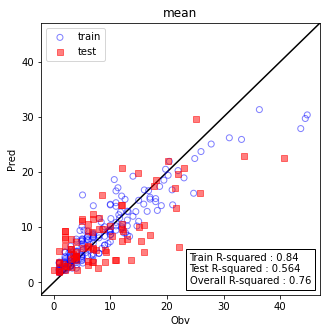

In [79]:
from sklearn.metrics import r2_score, mean_squared_error
def RF_cv(n_estimators, max_depth,# min_samples_leaf,
          min_samples_split):
          #silent=True, nthread=-1
        

      # 모델 정의
    model = RandomForestRegressor(n_estimators = int(n_estimators),
                                  max_depth = int(max_depth),
 #                                 min_samples_leaf = int(min_samples_leaf),
                                  min_samples_split = int(min_samples_split), random_state = 42)
#     scores = cross_val_score(model, x_train,y_train.values.ravel(),cv=3, scoring = 'r2')
#     total_score = scores.mean()
    
#     return total_score

    
    # 모델 훈련
    model.fit(x_95q_train, y_95q_train.values.ravel())

      # 예측값 출력
    y_pred= model.predict(x_95q_test)
    r2 = r2_score(y_95q_test, y_pred)
    train_predict = model.predict(x_95q_train)
    r2_train = r2_score(y_95q_train,train_predict)
    if r2_train > 0.86:
        r2 -= 0.3
    else: 
        r2 = r2
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'n_estimators' : (50, 300),
           'max_depth' : (6,10),
#            'min_samples_leaf' : (6,15),
           'min_samples_split' : (4, 20)
          }

bo=BayesianOptimization(f=RF_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=5, n_iter=100, acq='ei', xi=0.01)

bo.max

model = RandomForestRegressor(n_estimators = int(bo.max['params']['n_estimators']), max_depth =int(bo.max['params']['max_depth']), min_samples_split = int(bo.max['params']['min_samples_split']))
model.fit(x_95q_train,y_95q_train.values.ravel())
rf_predict = model.predict(x_95q_test)
train_predict = model.predict(x_95q_train)
score = cross_val_score(model, x_95q_train, y_95q_train.values.ravel(), cv = 5,scoring='r2')
cv_score = score.mean()
print( score, 'score')
print(  cv_score, 'mean score')

score = cross_val_score(model, x_95q_train, y_95q_train.values.ravel(), cv = 5,scoring='neg_mean_squared_error')
cv_score = score.mean()
print(np.sqrt(-1 * score), 'score')
print(np.sqrt(-1 * cv_score), 'mean score')
make_pred_obv_plot(y_95q_test,y_95q_train,rf_predict,train_predict,'mean')

0.564 test r-squared
0.845 train r-squared
5.093896088240057 test RMSE
3.1396224315703485 train RMSE


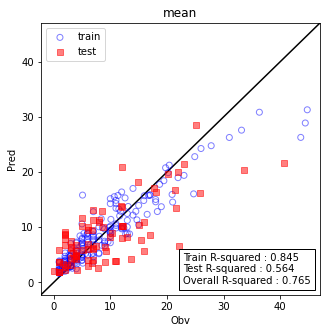

In [37]:
q_rf = RandomForestRegressor(n_estimators = 148, max_depth =7, min_samples_split = 8)
q_rf.fit(x_95q_train,y_95q_train.values.ravel())
rf_predict = q_rf.predict(x_95q_test)
train_predict = q_rf.predict(x_95q_train)

make_pred_obv_plot(y_95q_test,y_95q_train,rf_predict,train_predict,'mean')


In [38]:

error_put(q_rf,x_95q_train,x_95q_test,y_95q_train,y_95q_test, q_error_train,q_error_test, q_error_total, 'RF')

In [39]:
q_error_train

id        RF
41   103  3.309114
562  786  1.192773
119  217  1.869595
281  425 -0.381697
523  726  1.596177
..   ...       ...
240  373  0.554346
42   104  5.822352
112  203 -0.291634
487  679  1.300893
192  312 -1.621130

[198 rows x 2 columns]

### smote

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.2916   |  7.668    |  15.53    |  50.03    |
|  2        |  0.3069   |  7.209    |  6.348    |  73.08    |
|  3        |  0.3058   |  6.745    |  9.529    |  149.2    |
|  4        |  0.3046   |  8.155    |  10.71    |  221.3    |
|  5        |  0.5881   |  6.818    |  18.05    |  56.85    |
|  6        |  0.5824   |  7.449    |  18.32    |  55.84    |
|  7        |  0.5807   |  8.176    |  20.0     |  57.65    |
|  8        |  0.2883   |  9.482    |  16.32    |  58.96    |
|  9        |  0.5875   |  7.655    |  19.7     |  54.82    |
|  10       |  0.5892   |  6.025    |  19.2     |  56.78    |
|  11       |  0.5876   |  7.162    |  19.88    |  56.83    |
|  12       |  0.5988   |  6.96     |  17.74    |  298.3    |
|  13       |  0.2998   |  7.86     |  17.49    |  295.1    |
|  14       |  0.3009   |  7.634    |  16.97    |  300.0    |
|  15   

|  80       |  0.2915   |  6.42     |  15.58    |  62.95    |
|  81       |  0.5895   |  6.086    |  19.13    |  59.71    |
|  82       |  0.5889   |  6.043    |  17.82    |  63.22    |
|  83       |  0.59     |  6.606    |  19.63    |  60.36    |
|  84       |  0.5932   |  6.085    |  17.97    |  59.83    |
|  85       |  0.2865   |  9.575    |  19.54    |  57.1     |
|  86       |  0.5875   |  7.142    |  19.92    |  58.29    |
|  87       |  0.588    |  7.35     |  19.51    |  59.59    |
|  88       |  0.5892   |  6.093    |  17.63    |  65.29    |
|  89       |  0.2883   |  9.008    |  19.24    |  54.38    |
|  90       |  0.5859   |  8.184    |  19.87    |  56.4     |
|  91       |  0.5896   |  6.256    |  19.97    |  54.66    |
|  92       |  0.5845   |  7.501    |  18.74    |  66.23    |
|  93       |  0.5842   |  7.11     |  18.77    |  57.37    |
|  94       |  0.5873   |  7.313    |  19.34    |  62.38    |
|  95       |  0.3095   |  7.936    |  10.65    |  245.2    |
|  96   

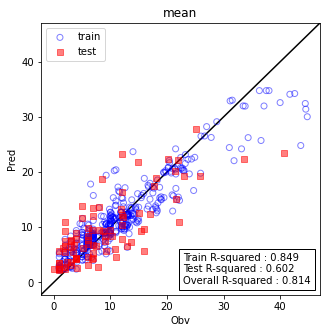

In [80]:
from sklearn.metrics import r2_score, mean_squared_error
def RF_cv(n_estimators, max_depth,# min_samples_leaf,
          min_samples_split):
          #silent=True, nthread=-1
        

      # 모델 정의
    model = RandomForestRegressor(n_estimators = int(n_estimators),
                                  max_depth = int(max_depth),
 #                                 min_samples_leaf = int(min_samples_leaf),
                                  min_samples_split = int(min_samples_split), random_state = 42)
#     scores = cross_val_score(model, x_train,y_train.values.ravel(),cv=3, scoring = 'r2')
#     total_score = scores.mean()
    
#     return total_score

    
    # 모델 훈련

    model.fit(x_train_smote, y_train_smote)
    train_predict = model.predict(x_train_smote)
    r2_train = r2_score(y_train_smote,train_predict)
    y_pred= model.predict(x_test_smote)
    r2 = r2_score(y_test_smote, y_pred)
      # 예측값 출력

    if r2_train > 0.86:
        r2 -= 0.3
    else: 
        r2 = r2
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'n_estimators' : (50, 300),
           'max_depth' : (6,10),
#            'min_samples_leaf' : (6,15),
           'min_samples_split' : (4, 20)
          }

bo=BayesianOptimization(f=RF_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=5, n_iter=100, acq='ei', xi=0.01)

bo.max

model = RandomForestRegressor(n_estimators = int(bo.max['params']['n_estimators']), max_depth =int(bo.max['params']['max_depth']), min_samples_split = int(bo.max['params']['min_samples_split']))
model.fit(x_train_smote, y_train_smote.values.ravel())
score = cross_val_score(model, x_train_smote, y_train_smote.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
rf_predict = model.predict(x_test_smote)
train_predict = model.predict(x_train_smote)


score = cross_val_score(model, x_train_smote, y_train_smote.values.ravel(), cv = 5,scoring='neg_mean_squared_error')
cv_score = score.mean()
print(np.sqrt(-1 * score), 'score')
print(np.sqrt(-1 * cv_score), 'mean score')
make_pred_obv_plot(y_test_smote,y_train_smote,rf_predict,train_predict,'mean')

0.591 test r-squared
0.847 train r-squared
4.9321599209971465 test RMSE
3.2446970660336683 train RMSE


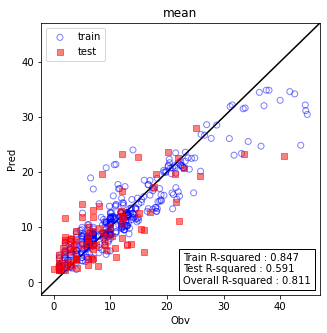

In [40]:

smote_rf = RandomForestRegressor(n_estimators = 201, max_depth =6, min_samples_split = 18)
smote_rf.fit(x_train_smote, y_train_smote.values.ravel())

rf_predict = smote_rf.predict(x_test_smote)
train_predict = smote_rf.predict(x_train_smote)

make_pred_obv_plot(y_test_smote,y_train_smote,rf_predict,train_predict,'mean')

In [41]:

error_put(smote_rf,x_95q_train,x_95q_test,y_95q_train,y_95q_test, smote_error_train,smote_error_test, smote_error_total, 'RF')

# XGB

## Mean

In [44]:
import xgboost as xgb

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.5769   |  0.6251   |  0.07231  |  6.0      |  186.0    |
|  2        |  0.4689   |  0.544    |  0.01014  |  6.745    |  205.5    |
|  3        |  0.6045   |  0.619    |  0.05434  |  7.677    |  358.3    |
|  4        |  0.5683   |  0.5613   |  0.08793  |  6.11     |  351.7    |
|  5        |  0.5996   |  0.6252   |  0.05631  |  6.562    |  139.1    |
|  6        |  0.5612   |  0.7402   |  0.09686  |  7.254    |  361.5    |
|  7        |  0.544    |  0.7629   |  0.08957  |  6.34     |  67.57    |
|  8        |  0.5781   |  0.5509   |  0.08794  |  6.393    |  239.5    |
|  9        |  0.5852   |  0.7874   |  0.05378  |  8.768    |  192.0    |
|  10       |  0.5618   |  0.706    |  0.08363  |  6.073    |  387.6    |
|  11       |  0.582    |  0.7967   |  0.07507  |  7.122    |  405.2    |
|  12       |  0.6075   |  0.531    | 

[0.62481176 0.56513526 0.62635142 0.68810731 0.65312815] cv - score
0.6315067792477584 cv mean - score
0.619 test r-squared
0.84 train r-squared
1.7719582618304226 test RMSE
1.3698671320346052 train RMSE


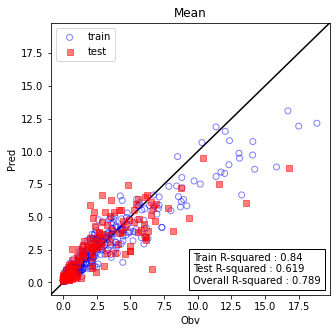

In [80]:
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
def XGB_cv(max_depth,learning_rate, n_estimators,
           gamma
             ,silent=True, nthread=-1):

      # 모델 정의
    model = xgb.XGBRegressor(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                gamma=gamma,
                                subsample = 0.5,
                                nthread=nthread
                                )
#    scores = cross_val_score(model, x_train,y_train.values.ravel(),cv=3, scoring = 'r2')
#    total_score = scores.mean()
    
    # 모델 훈련
    model.fit(x_train, np.log1p(y_train).values.ravel())

      # 예측값 출력
    y_pred= model.predict(x_test)
    r2 = r2_score(y_test, np.expm1(y_pred))
    return r2
#     score = cross_val_score(model, x_train, np.log1p(y_train).values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
#     cv_score = score.mean()
    
#       # 예측값 출력
#     return cv_score

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (6, 10),
                'learning_rate': (0.001,0.1),
                'n_estimators': (50,500),
                'gamma': (0.5, 0.8),
          }
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=15, n_iter=50, acq='ei', xi=0.1)
print(bo.max)
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators = int(bo.max['params']['n_estimators']),
                         learning_rate = bo.max['params']['learning_rate'], max_depth = int(bo.max['params']['max_depth']), gamma =  bo.max['params']['gamma'],subsample = 0.5)
score = cross_val_score(xgb_model, x_train, np.log1p(y_train).values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
xgb_model.fit(x_train,np.log1p(y_train).values.ravel())
xgb_predict = xgb_model.predict(x_test)
xgb_train_predict = xgb_model.predict(x_train)

make_pred_obv_plot(y_test,y_train,np.expm1(xgb_predict),np.expm1(xgb_train_predict),'Mean')


In [36]:
from xgboost import XGBRegressor

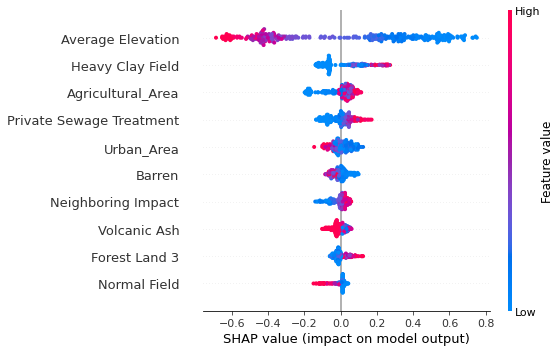

In [85]:
mean_xgb = XGBRegressor(n_estimators = int(332.7163382861621),
                         learning_rate = 0.044678323006951494, max_depth = int(6.079689990356894), gamma =  0.5565162407741838,subsample = 0.5)

mean_xgb.fit(x_train,np.log1p(y_train).values.ravel())
xgb_predict = mean_xgb.predict(x_test)
xgb_train_predict = mean_xgb.predict(x_train)

#make_pred_obv_plot(y_test,y_train,np.expm1(xgb_predict),np.expm1(xgb_train_predict),'Mean')

shap_model(mean_xgb, x_train)

In [110]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)

error_put(mean_xgb,np.log1p(x_train),np.log1p(x_test),y_train,y_test, mean_error_train,mean_error_test, mean_error_total, 'XGB')

In [111]:
mean_error_train

id        RF       XGB       NGB       SVM       ANN
532  741 -0.116695  1.060687 -0.724328 -0.223806 -0.891409
361  520 -0.010804  0.770588 -0.116473 -0.034882 -0.570884
443  620  0.030556  3.060215  0.006732  0.100271  0.455107
259  396 -1.050796 -2.252363 -2.373223 -1.350872 -1.480621
448  625  0.913962 -0.159512  1.139819 -0.074665 -0.939080
..   ...       ...       ...       ...       ...       ...
93   178  0.072300  2.667644  0.080321  0.609337  0.106288
330  485  0.485132  1.647093  0.605319  0.099704 -0.463549
487  679  0.618506  2.387243  0.570403  0.099481  0.096954
131  229  0.103516  0.748130  1.408810  0.100159 -0.404694
559  783 -0.198058  0.255029 -0.733053 -0.406547 -1.338957

[308 rows x 6 columns]

## Median

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        |  0.1329   |  0.2834   |  4.881    |  20.0     |
|  2        |  0.4348   |  0.2605   |  2.587    |  21.85    |
|  3        |  0.102    |  0.2373   |  3.382    |  27.94    |
|  4        |  0.1059   |  0.3078   |  3.677    |  33.7     |
|  5        |  0.07984  |  0.2409   |  5.512    |  20.55    |
|  6        |  0.05457  |  0.3341   |  3.669    |  31.17    |
|  7        |  0.4155   |  0.2281   |  2.792    |  36.01    |
|  8        |  0.1242   |  0.3937   |  3.254    |  33.85    |
|  9        |  0.09483  |  0.3753   |  5.578    |  21.7     |
|  10       |  0.4326   |  0.2078   |  2.679    |  37.56    |
|  11       |  0.09466  |  0.2197   |  3.684    |  39.16    |
|  12       |  0.1023   |  0.3066   |  4.768    |  26.31    |
|  13       |  0.0877   |  0.3373   |  5.339    |  20.37    |
|  14       |  0.08274  |  0.35     |  5.955    |  34.96    |
|  15   

|  81       |  0.3888   |  0.3902   |  2.015    |  31.02    |
|  82       |  0.4375   |  0.2203   |  2.694    |  32.26    |
|  83       |  0.09823  |  0.4      |  2.363    |  36.65    |
|  84       |  0.4423   |  0.2022   |  2.108    |  35.57    |
|  85       |  0.4169   |  0.2366   |  2.976    |  37.09    |
|  86       |  0.4341   |  0.2184   |  2.18     |  32.09    |
|  87       |  0.4372   |  0.2239   |  2.375    |  23.14    |
|  88       |  0.4309   |  0.2012   |  2.391    |  21.15    |
|  89       |  0.4058   |  0.3978   |  2.658    |  29.35    |
|  90       |  0.4384   |  0.2083   |  2.042    |  37.67    |
|  91       |  0.4399   |  0.2003   |  2.022    |  21.94    |
|  92       |  0.4237   |  0.2412   |  2.998    |  20.03    |
|  93       |  0.3612   |  0.3927   |  2.348    |  34.52    |
|  94       |  0.445    |  0.2123   |  2.489    |  33.0     |
|  95       |  0.09878  |  0.3976   |  5.999    |  36.89    |
|  96       |  0.1164   |  0.3678   |  3.407    |  26.33    |
|  97   

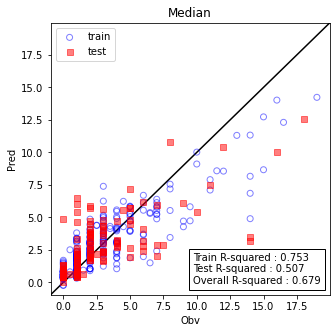

In [330]:
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
def XGB_cv(max_depth,learning_rate, n_estimators,
    #       gamma,
           silent=True, nthread=-1):

      # 모델 정의
    model = xgb.XGBRegressor(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                        #        gamma=gamma,
                                nthread=nthread
                                )
    scores = cross_val_score(model, x_med_train,y_med_train.values.ravel(),cv=5, scoring = 'r2')
    total_score = scores.mean()
    
    # 모델 훈련
    model.fit(x_med_train, y_med_train.values.ravel())

      # 예측값 출력
    y_pred= model.predict(x_med_test)
    temp_xgb_train_predict = model.predict(x_med_train)
    train_r2 = r2_score(y_med_train,temp_xgb_train_predict)
    r2 = r2_score(y_med_test, y_pred)
    if train_r2 < 0.86:
        return total_score
    else:
        return total_score - 0.3
from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (2, 6),
                'learning_rate': (0.2,0.4),
                'n_estimators': (20,40)
#                'gamma': (0.5, 0.7)
          }
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=50, n_iter=100, acq='ei', xi=0.1)
print(bo.max)
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators = int(bo.max['params']['n_estimators']),
                         learning_rate = bo.max['params']['learning_rate'],
                         max_depth = int(bo.max['params']['max_depth']))
#                         gamma =  bo.max['params']['gamma'])
xgb_model.fit(x_med_train, y_med_train.values.ravel())
score = cross_val_score(xgb_model, x_med_train, y_med_train.values.ravel(), cv = 5,scoring='r2')
cv_score = score.mean()
print(score)
print(cv_score)
xgb_predict = xgb_model.predict(x_med_test)
xgb_train_predict = xgb_model.predict(x_med_train)

make_pred_obv_plot(y_med_test,y_med_train,xgb_predict, xgb_train_predict,'Median')


[0.35925628 0.63098438 0.40927743 0.34102306 0.34977312]
0.41806285369114315
0.53 test r-squared
0.863 train r-squared
2.260085880493426 test RMSE
1.2171019374822745 train RMSE


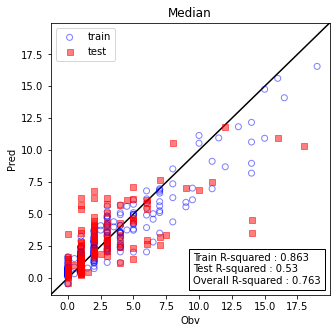

In [42]:
from xgboost import XGBRegressor
med_xgb = XGBRegressor(n_estimators = 42,
                         learning_rate = 0.3162557058281329,
                         max_depth = 2,
                         gamma =  0.6753391447890811)

med_xgb.fit(x_med_train, y_med_train.values.ravel())

xgb_predict = med_xgb.predict(x_med_test)
xgb_train_predict = med_xgb.predict(x_med_train)

score = cross_val_score(med_xgb, x_med_train, y_med_train.values.ravel(), cv = 5,scoring='r2')
cv_score = score.mean()
print(score)
print(cv_score)

make_pred_obv_plot(y_med_test,y_med_train,xgb_predict, xgb_train_predict,'Median')


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


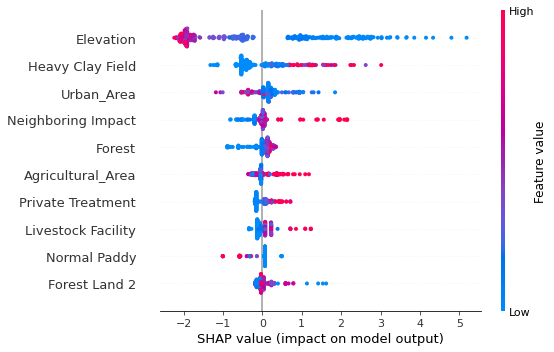

In [45]:
shap_model(med_xgb, x_med_train)

In [44]:
x_med_train.columns = ['Urban_Area', 'Agricultural_Area', 'Forest', 'Pasture', 'Barren',
       'Basic Rock', 'Sedimentary Rock', 'Volcanic Ash', 'Normal Paddy',
       'Immatured Paddy', 'Normal Field', 'Forest Land 2', 'Sandy Field',
       'Heavy Clay Field', 'Forest Land 3', 'Private Treatment',
       'Artificial Recharge Well', 'Detention Pond', 'Geothermal Facility',
       'Specified Waste Discharge Facility',
       'Livestock Facility', 'Soil contamination Facility',
       'Wastewater Discharge Facility', 'Elevation', 'Neighboring Impact']

In [50]:

error_put(med_xgb,x_med_train,x_med_test,y_med_train,y_med_test, med_error_train,med_error_test, med_error_total, 'XGB')

In [51]:
med_error_train

id        RF       XGB
65   140 -2.913799 -3.688300
13    53 -4.755629 -5.025908
456  638 -0.628047 -0.473452
482  674  1.831857  1.097578
417  590 -0.695249 -0.361343
..   ...       ...       ...
485  677  0.284691  0.352483
520  723 -0.024703 -0.392319
244  381  1.536389  1.396466
206  330  0.177569  0.347929
131  229  3.154153  0.895900

[308 rows x 3 columns]

[0.41543161 0.69767136 0.43412856 0.4023007  0.36392097]
0.46269064223444845
0.52 test r-squared
0.763 train r-squared
2.2850354542542197 test RMSE
1.601279791763561 train RMSE


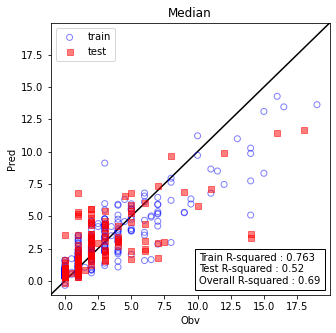

In [190]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators = 26,
                         learning_rate = 0.27770349454756005,
                         max_depth = 2,
                         gamma =  0.3142464059471038)
xgb_model.fit(x_med_train, y_med_train.values.ravel())
xgb_predict = xgb_model.predict(x_med_test)
xgb_train_predict = xgb_model.predict(x_med_train)
score = cross_val_score(xgb_model, x_med_train, y_med_train.values.ravel(), cv = 5,scoring='r2')
cv_score = score.mean()
print(score)
print(cv_score)
make_pred_obv_plot(y_med_test,y_med_train,xgb_predict, xgb_train_predict,'Median')


## 95q

### original

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.5508   |  0.7085   |  0.07231  |  2.0      |  110.5    |
|  2        |  0.1637   |  0.5734   |  0.01014  |  2.559    |  119.1    |
|  3        |  0.5629   |  0.6984   |  0.05434  |  3.258    |  187.0    |
|  4        |  0.5607   |  0.6022   |  0.08793  |  2.082    |  184.1    |
|  5        |  0.549    |  0.7087   |  0.05631  |  2.421    |  89.62    |
|  6        |  0.5858   |  0.9004   |  0.09686  |  2.94     |  188.5    |
|  7        |  0.5795   |  0.9382   |  0.08957  |  2.255    |  57.81    |
|  8        |  0.5678   |  0.5849   |  0.08794  |  2.295    |  134.2    |
|  9        |  0.5303   |  0.9789   |  0.05378  |  4.076    |  113.1    |
|  10       |  0.5746   |  0.8433   |  0.08363  |  2.055    |  200.0    |
|  11       |  0.5724   |  0.9944   |  0.07507  |  2.841    |  207.9    |
|  12       |  0.5501   |  0.5516   | 

[0.56332284 0.6106745  0.59954945 0.38246603 0.43201819] cv - score
0.517606201883959 cv mean - score
0.588 test r-squared
0.816 train r-squared
4.953996347064476 test RMSE
3.4235162139228565 train RMSE


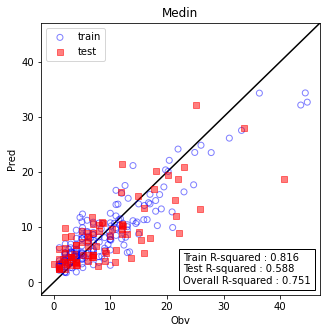

In [307]:
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
def XGB_cv(max_depth,learning_rate, n_estimators,
           gamma
             ,silent=True, nthread=-1):

      # 모델 정의
    model = xgb.XGBRegressor(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                gamma=gamma,
                                subsample = 0.5,
                                nthread=nthread, reg_lambda = 2.5
                                )
#    scores = cross_val_score(model, x_train,y_train.values.ravel(),cv=3, scoring = 'r2')
#    total_score = scores.mean()
    
    # 모델 훈련
    model.fit(x_95q_train, y_95q_train.values.ravel())

      # 예측값 출력
    y_pred= model.predict(x_95q_test)
    r2 = r2_score(y_95q_test, y_pred)
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (2,5),
                'learning_rate': (0.001,0.1),
                'n_estimators': (50,250),
                'gamma': (0.5, 1),
          }
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=15, n_iter=50, acq='ei', xi=0.1)
print(bo.max)
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators = int(bo.max['params']['n_estimators']),
                         learning_rate = bo.max['params']['learning_rate'], max_depth = int(bo.max['params']['max_depth']), gamma =  bo.max['params']['gamma'],subsample = 0.5, reg_lambda = 2.5)
xgb_model.fit(x_95q_train,y_95q_train.values.ravel())
score = cross_val_score(xgb_model, x_95q_train, y_95q_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
xgb_predict = xgb_model.predict(x_95q_test)
xgb_train_predict = xgb_model.predict(x_95q_train)

make_pred_obv_plot(y_95q_test,y_95q_train,xgb_predict,xgb_train_predict,'Medin')


0.588 test r-squared
0.816 train r-squared
4.953996347064476 test RMSE
3.4235162139228565 train RMSE


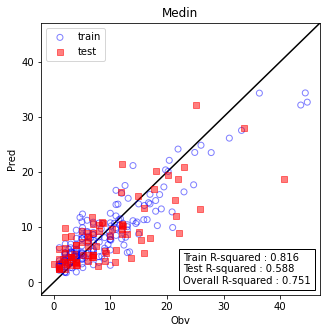

In [46]:
q_xgb = XGBRegressor(n_estimators =55,
                         learning_rate = 0.1, max_depth = 2, gamma = 1,subsample = 0.5, reg_lambda = 2.5)
q_xgb.fit(x_95q_train,y_95q_train.values.ravel())
xgb_predict = q_xgb.predict(x_95q_test)
xgb_train_predict = q_xgb.predict(x_95q_train)

make_pred_obv_plot(y_95q_test,y_95q_train,xgb_predict,xgb_train_predict,'Medin')


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


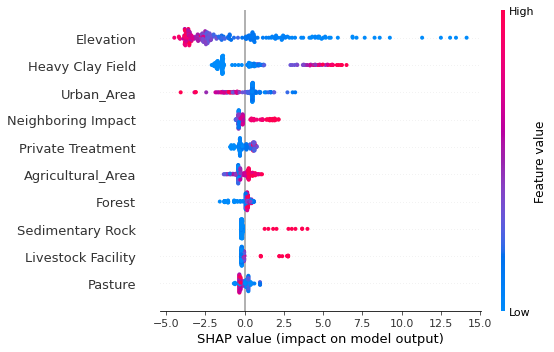

In [48]:
shap_model(q_xgb, x_95q_train)

In [47]:
x_95q_train.columns = ['Urban_Area', 'Agricultural_Area', 'Forest', 'Pasture', 'Barren',
       'Basic Rock', 'Sedimentary Rock', 'Volcanic Ash', 'Normal Paddy',
       'Immatured Paddy', 'Normal Field', 'Forest Land 2', 'Sandy Field',
       'Heavy Clay Field', 'Forest Land 3', 'Private Treatment',
       'Artificial Recharge Well', 'Detention Pond', 'Geothermal Facility',
       'Specified Waste Discharge Facility',
       'Livestock Facility', 'Soil contamination Facility',
       'Wastewater Discharge Facility', 'Elevation', 'Neighboring Impact']

In [53]:

error_put(q_xgb,x_95q_train,x_95q_test,y_95q_train,y_95q_test, q_error_train,q_error_test, q_error_total, 'XGB')

In [198]:
q_error_train

id        RF       XGB
41   103  4.621664  5.684599
562  786  1.480967  0.883528
119  217  1.665547  2.950858
281  425  0.021388 -1.056540
523  726  1.535093  1.997796
..   ...       ...       ...
240  373  0.373606  0.810940
42   104  7.893097  3.911778
112  203 -0.438411  0.737559
487  679  1.331059  1.787508
192  312 -1.665170 -3.830135

[198 rows x 3 columns]

### smote

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.2948   |  0.7085   |  0.07231  |  2.0      |  110.5    |
|  2        |  0.3055   |  0.5734   |  0.01014  |  2.559    |  119.1    |
|  3        |  0.3014   |  0.6984   |  0.05434  |  3.258    |  187.0    |
|  4        |  0.2778   |  0.6022   |  0.08793  |  2.082    |  184.1    |
|  5        |  0.5997   |  0.7087   |  0.05631  |  2.421    |  89.62    |
|  6        |  0.2449   |  0.9004   |  0.09686  |  2.94     |  188.5    |
|  7        |  0.5912   |  0.9382   |  0.08957  |  2.255    |  57.81    |
|  8        |  0.2734   |  0.5849   |  0.08794  |  2.295    |  134.2    |
|  9        |  0.3047   |  0.9789   |  0.05378  |  4.076    |  113.1    |
|  10       |  0.2844   |  0.8433   |  0.08363  |  2.055    |  200.0    |
|  11       |  0.2952   |  0.9944   |  0.07507  |  2.841    |  207.9    |
|  12       |  0.301    |  0.5516   | 

[0.7162644  0.72277446 0.73040515 0.80561181 0.66332521] cv - score
0.7276762038670672 cv mean - score
0.609 test r-squared
0.848 train r-squared
4.821968683808014 test RMSE
3.2302670194778664 train RMSE


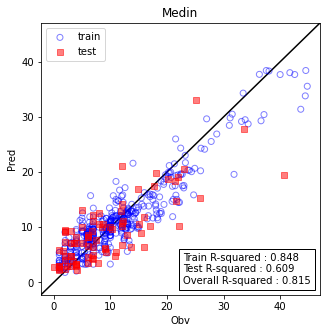

In [308]:
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
def XGB_cv(max_depth,learning_rate, n_estimators,
           gamma
             ,silent=True, nthread=-1):

      # 모델 정의
    model = xgb.XGBRegressor(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                gamma=gamma,
                                subsample = 0.5,
                                nthread=nthread, reg_lambda = 2.5
                                )
#    scores = cross_val_score(model, x_train,y_train.values.ravel(),cv=3, scoring = 'r2')
#    total_score = scores.mean()
    
    # 모델 훈련
    model.fit(x_train_smote, y_train_smote)
    train_predict = model.predict(x_train_smote)
    r2_train = r2_score(y_train_smote,train_predict)
    y_pred= model.predict(x_test_smote)
    r2 = r2_score(y_test_smote, y_pred)
    if r2_train > 0.86:
        r2 -= 0.3
    else: 
        r2 = r2
    return r2
      # 예측값 출력

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (2,5),
                'learning_rate': (0.001,0.1),
                'n_estimators': (50,250),
                'gamma': (0.5, 1),
          }
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=15, n_iter=50, acq='ei', xi=0.1)
print(bo.max)
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators = int(bo.max['params']['n_estimators']),
                         learning_rate = bo.max['params']['learning_rate'], max_depth = int(bo.max['params']['max_depth']), gamma =  bo.max['params']['gamma'],subsample = 0.5, reg_lambda = 2.5)
xgb_model.fit(x_train_smote, y_train_smote)
score = cross_val_score(xgb_model, x_train_smote, y_train_smote.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
xgb_predict = xgb_model.predict(x_test_smote)
xgb_train_predict = xgb_model.predict(x_train_smote)

make_pred_obv_plot(y_test_smote,y_train_smote,xgb_predict,xgb_train_predict,'Medin')


0.608 test r-squared
0.845 train r-squared
4.830671019614559 test RMSE
3.2661562213373525 train RMSE


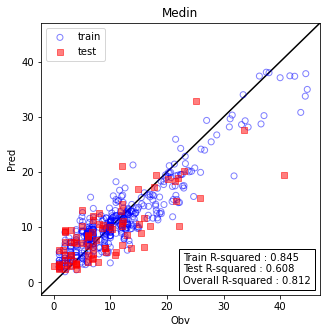

In [54]:
from xgboost import XGBRegressor
smote_xgb = XGBRegressor(n_estimators = 86,
                         learning_rate =0.0603954562271922 , max_depth = 2, gamma = 0.6019226020159718 ,subsample = 0.5, reg_lambda = 2.5)
smote_xgb.fit(x_train_smote, y_train_smote)
xgb_predict = smote_xgb.predict(x_test_smote)
xgb_train_predict = smote_xgb.predict(x_train_smote)

make_pred_obv_plot(y_test_smote,y_train_smote,xgb_predict,xgb_train_predict,'Medin')


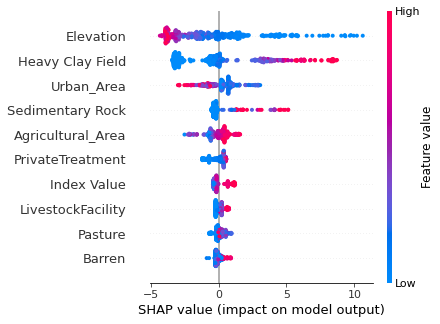

In [93]:
shap_model(smote_xgb, x_train_smote)

In [34]:
import shap

def shap_model(model, x_train):

    shap.initjs()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_train)
    shap.summary_plot(shap_values, x_train, max_display = 10, plot_size = (8,5))


In [74]:
x_train_smote.columns = ['Urban_Area', 'Agricultural_Area', 'Forest', 'Pasture', 'Barren',
       'Basic Rock', 'Sedimentary Rock', 'Volcanic Ash', 'Normal Paddy',
       'Immatured Paddy', 'Normal Field', 'Forest Land 2', 'Sandy Field',
       'Heavy Clay Field', 'Forest Land 3', 'PrivateTreatment',
       'Artificial Recharge Well', 'Detention Pond', 'Geothermal Facility',
       'Specified Waste Discharge Facility',
       'LivestockFacility', 'Soil contamination Facility',
       'Wastewater Discharge Facility', 'Elevation', 'Index Value']

In [55]:

error_put(smote_xgb,x_95q_train,x_95q_test,y_95q_train,y_95q_test,smote_error_train,smote_error_test, smote_error_total, 'XGB')

In [205]:
smote_error_train

id        RF       XGB
41   103  8.471294  7.243557
562  786  2.481166  3.229555
119  217  4.443850  3.789663
281  425 -0.229391 -0.767479
523  726  2.176482  3.000296
..   ...       ...       ...
240  373  3.289568  3.553000
42   104  9.006672  6.408502
112  203  0.163601  0.838310
487  679  1.538700  1.801277
192  312 -1.034741 -1.916119

[198 rows x 3 columns]

# NGBoost

## Mean

In [39]:
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
[iter 100] loss=0.8493 val_loss=0.0000 scale=2.0000 norm=0.5856
|  1        | -4.11e+25 |  0.1126   |  158.0    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
|  2        |  0.5797   |  0.05002  |  95.35    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
|  3        |  0.6045   |  0.07201  |  63.85    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
[iter 100] loss=1.1649 val_loss=0.0000 scale=4.0000 norm=1.2118
|  4        |  0.6057   |  0.07794  |  101.8    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
[iter 100] loss=-0.4354 val_loss=0.0000 scale=4.0000 norm=1.0355
|  5        | -6.603e+1 |  0.1095   |  130.8    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
[iter 100] loss=0.5782 val_loss=0.0000 scale=16.0000 norm=4.7206
|  6        |  0.454

[iter 100] loss=-0.8548 val_loss=0.0000 scale=8.0000 norm=2.2518
|  45       | -2.56e+03 |  0.199    |  194.5    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
[iter 100] loss=-0.0544 val_loss=0.0000 scale=2.0000 norm=0.4913
|  46       | -1.511e+0 |  0.2      |  155.5    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
|  47       | -0.2068   |  0.1866   |  77.17    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
|  48       |  0.4461   |  0.07209  |  87.48    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
[iter 100] loss=1.3726 val_loss=0.0000 scale=2.0000 norm=0.6745
|  49       |  0.5389   |  0.05035  |  140.9    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
[iter 100] loss=-1.9273 val_loss=0.0000 scale=4.0000 norm=0.9415
|  50       | -9.393e+2 |  0.1887   |  184.1    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
|  51       |  0.3572   |  0.1724   |  66.06    |
[iter 0] loss=2.178

|  89       |  0.4367   |  0.1084   |  156.8    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
|  90       | -0.406    |  0.1972   |  57.11    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
|  91       |  0.1975   |  0.1667   |  75.89    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
|  92       |  0.569    |  0.1267   |  96.98    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
|  93       |  0.2026   |  0.1815   |  81.03    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
[iter 100] loss=0.1803 val_loss=0.0000 scale=4.0000 norm=1.1168
|  94       | -3.426e+1 |  0.1311   |  190.4    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
[iter 100] loss=0.2646 val_loss=0.0000 scale=4.0000 norm=1.1322
|  95       |  0.5369   |  0.1695   |  137.5    |
[iter 0] loss=2.1787 val_loss=0.0000 scale=2.0000 norm=1.5146
[iter 100] loss=1.4602 val_loss=0.0000 scale=2.0000 norm=0.7131
|  96       |  0.6011   

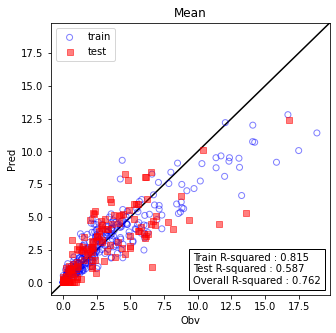

In [51]:
### 베이지안 
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)

from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal
def ngb_cv(learning_rate, n_estimators, silent=True):

      # 모델 정의
    model = NGBRegressor(Dist = Exponential,learning_rate=learning_rate,n_estimators=int(n_estimators), col_sample = 0.7 )
      # 모델 훈련
    model.fit(x_train, y_train)

      # 예측값 출력
    y_pred= model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    return r2
#     score = cross_val_score(model, x_train, np.log1p(y_train).values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
#     cv_score = score.mean()
    
#       # 예측값 출력
#     return cv_score

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'learning_rate': (0.05, 0.2),
           'n_estimators': (50,200)}
bo=BayesianOptimization(f=ngb_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=10, n_iter=100, acq='ei', xi=0.02)
print(bo.max)


from ngboost import NGBRegressor
ngb_model = NGBRegressor(Dist = Exponential,n_estimators =int(bo.max['params']['n_estimators']), learning_rate =bo.max['params']['learning_rate'],col_sample = 0.7)
score = cross_val_score(ngb_model, x_train, y_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
ngb_model.fit(x_train, y_train)
ngb_predict = ngb_model.predict(x_test)
ngb_train_predict = ngb_model.predict(x_train)

make_pred_obv_plot(y_test,y_train,ngb_predict,ngb_train_predict,'Mean')


Translating model_ouput="raw" to model_output=0 for the 0-th parameter in the distribution. Use model_output=0 directly to avoid this warning.


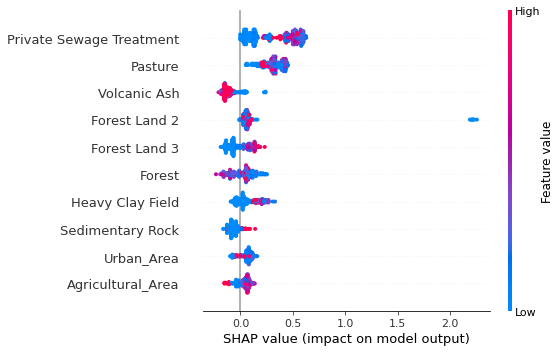

In [83]:
# SEED=42
# import random
# import os
# import tensorflow as tf
# def seed_everything(seed: int = 42):
#     random.seed(seed)
#     np.random.seed(seed)
#     os.environ["PYTHONHASHSEED"] = str(seed)
#     tf.random.set_seed(seed)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'

# seed_everything(42)

from ngboost import NGBRegressor
#{'learning_rate': 0.050017156222601736, 'n_estimators': 95.34988589477597}}
mean_ngb = NGBRegressor(Dist = Exponential,n_estimators =68, learning_rate =0.07172077910559901, col_sample = 0.7,verbose=False, random_state= 42)

mean_ngb.fit(x_train, y_train)
ngb_predict = mean_ngb.predict(x_test)
ngb_train_predict = mean_ngb.predict(x_train)

#make_pred_obv_plot(y_test,y_train,ngb_predict,ngb_train_predict,'Mean')

shap_model(mean_ngb, x_train)


0.636 test r-squared
0.807 train r-squared
1.7323311331415343 test RMSE
1.5024877633677522 train RMSE


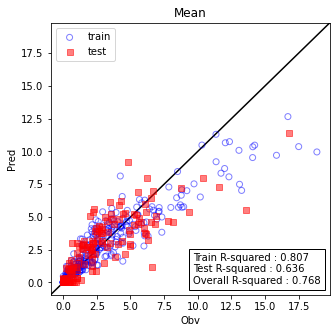

In [67]:
ngb_predict = mean_ngb.predict(x_test)
ngb_train_predict = mean_ngb.predict(x_train)

make_pred_obv_plot(y_test,y_train,ngb_predict,ngb_train_predict,'Mean')

Translating model_ouput="raw" to model_output=0 for the 0-th parameter in the distribution. Use model_output=0 directly to avoid this warning.


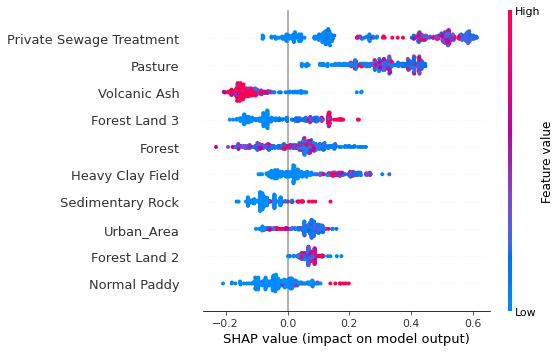

In [41]:
shap_model(mean_ngb, x_train)

In [68]:
x_train.columns = ['Urban_Area', 'Agricultural_Area', 'Forest', 'Pasture', 'Barren',
       'Basic Rock', 'Sedimentary Rock', 'Volcanic Ash', 'Normal Paddy',
       'Immatured Paddy', 'Normal Field', 'Forest Land 2', 'Sandy Field',
       'Heavy Clay Field', 'Forest Land 3', 'Private Treatment',
       'Artificial Recharge Well', 'Detention Pond', 'Geothermal Facility',
       'Specified Waste Discharge Facility',
       'Livestock manure Discharge Facility', 'Soil Facility',
       'Wastewater Discharge Facility', 'Elevation', 'Index Value']

In [58]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)


error_put(mean_ngb,x_train,x_test,y_train,y_test, mean_error_train,mean_error_test, mean_error_total, 'NGB')

In [59]:
mean_error_train

id        RF       XGB       NGB
532  741 -0.116695 -1.170446 -0.724328
361  520 -0.010804 -1.623317 -0.116473
443  620  0.030556  0.073772  0.006732
259  396 -1.050796 -3.751659 -2.373223
448  625  0.913962 -1.716116  1.139819
..   ...       ...       ...       ...
93   178  0.072300 -0.207877  0.080321
330  485  0.485132 -1.442778  0.605319
487  679  0.618506 -0.039842  0.570403
131  229  0.103516 -2.262167  1.408810
559  783 -0.198058 -2.094480 -0.733053

[308 rows x 4 columns]

## Median

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
[iter 0] loss=2.0251 val_loss=0.0000 scale=2.0000 norm=1.6472
[iter 100] loss=-5.6000 val_loss=0.0000 scale=4.0000 norm=2.1127
[iter 200] loss=-12.5824 val_loss=0.0000 scale=4.0000 norm=2.0315
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 norm=1.6389
[iter 100] loss=-6.2820 val_loss=0.0000 scale=4.0000 norm=1.8082
[iter 200] loss=-14.3070 val_loss=0.0000 scale=4.0000 norm=1.8816
[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=-6.5539 val_loss=0.0000 scale=4.0000 norm=1.8227
[iter 200] loss=-15.0288 val_loss=0.0000 scale=4.0000 norm=1.8024
[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=-6.5613 val_loss=0.0000 scale=4.0000 norm=2.1250
[iter 200] loss=-14.2128 val_loss=0.0000 scale=4.0000 norm=2.0136
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=-6.0722 val_loss=0.0000 scale=4.0000 norm=1.7091
[

[iter 100] loss=-7.7402 val_loss=0.0000 scale=4.0000 norm=1.9901
[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=-6.0832 val_loss=0.0000 scale=4.0000 norm=1.9246
[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=-7.6686 val_loss=0.0000 scale=8.0000 norm=4.3017
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=-8.1780 val_loss=0.0000 scale=4.0000 norm=2.1606
[iter 0] loss=2.0259 val_loss=0.0000 scale=2.0000 norm=1.6514
[iter 100] loss=-6.2486 val_loss=0.0000 scale=4.0000 norm=1.9881
|  9        |  0.3      |  0.2666   |  180.3    |
[iter 0] loss=2.0251 val_loss=0.0000 scale=2.0000 norm=1.6472
[iter 100] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=2.1313
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 norm=1.6389
[iter 100] loss=0.3750 val_loss=0.0000 scale=8.0000 norm=3.9927
[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=0.5665 val_loss=0.0000 scale=4.0000 norm=1.9433

C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])
C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])


[iter 100] loss=-7.7063 val_loss=0.0000 scale=8.0000 norm=3.5239
[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=-6.0320 val_loss=0.0000 scale=2.0000 norm=0.9811
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=-4.2327 val_loss=0.0000 scale=4.0000 norm=1.7767
[iter 0] loss=2.0259 val_loss=0.0000 scale=2.0000 norm=1.6514
[iter 100] loss=-4.4333 val_loss=0.0000 scale=2.0000 norm=0.8948
|  17       |  0.3      |  0.1762   |  177.5    |
[iter 0] loss=2.0251 val_loss=0.0000 scale=2.0000 norm=1.6472
[iter 100] loss=-0.1064 val_loss=0.0000 scale=4.0000 norm=2.0931
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 norm=1.6389
[iter 100] loss=-0.9052 val_loss=0.0000 scale=4.0000 norm=1.8842
[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=-0.5566 val_loss=0.0000 scale=8.0000 norm=3.7297


C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])
C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])


[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=-1.1070 val_loss=0.0000 scale=8.0000 norm=4.0851
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=0.1021 val_loss=0.0000 scale=4.0000 norm=1.9968
[iter 0] loss=2.0259 val_loss=0.0000 scale=2.0000 norm=1.6514
[iter 100] loss=-0.3773 val_loss=0.0000 scale=4.0000 norm=1.7893
|  18       |  0.5048   |  0.04705  |  180.2    |
[iter 0] loss=2.0251 val_loss=0.0000 scale=2.0000 norm=1.6472
[iter 100] loss=-9.8844 val_loss=0.0000 scale=4.0000 norm=2.6946
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 norm=1.6389
[iter 100] loss=-16.2338 val_loss=0.0000 scale=4.0000 norm=2.0435
[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=-11.3552 val_loss=0.0000 scale=2.0000 norm=1.0756
[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=-12.9574 val_loss=0.0000 scale=2.0000 norm=1.1524
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.62

C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])
C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])


[iter 100] loss=-4.4705 val_loss=0.0000 scale=4.0000 norm=2.0461
[iter 200] loss=-9.4381 val_loss=0.0000 scale=4.0000 norm=1.9716
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 norm=1.6389
[iter 100] loss=-5.1989 val_loss=0.0000 scale=2.0000 norm=1.0330
[iter 200] loss=-11.2694 val_loss=0.0000 scale=64.0000 norm=28.5240
[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=-4.4247 val_loss=0.0000 scale=4.0000 norm=1.7114
[iter 200] loss=-12.9247 val_loss=0.0000 scale=4.0000 norm=1.7950
[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=-5.9937 val_loss=0.0000 scale=4.0000 norm=2.2815
[iter 200] loss=-12.4677 val_loss=0.0000 scale=4.0000 norm=1.9860
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=-2.3837 val_loss=0.0000 scale=2.0000 norm=0.9145
[iter 200] loss=-7.2467 val_loss=0.0000 scale=4.0000 norm=1.8148
[iter 0] loss=2.0259 val_loss=0.0000 scale=2.0000 norm=1.6514
[iter 100] loss=-3.7436 val_loss=0.

[iter 100] loss=-9.2289 val_loss=0.0000 scale=2.0000 norm=1.1217
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 norm=1.6389
[iter 100] loss=-15.5064 val_loss=0.0000 scale=4.0000 norm=2.0188
[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=-8.3279 val_loss=0.0000 scale=2.0000 norm=0.9886
[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=-11.5368 val_loss=0.0000 scale=4.0000 norm=2.4924
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=-12.3605 val_loss=0.0000 scale=4.0000 norm=2.2394
[iter 0] loss=2.0259 val_loss=0.0000 scale=2.0000 norm=1.6514
[iter 100] loss=-8.9025 val_loss=0.0000 scale=4.0000 norm=2.1886
|  32       |  0.3      |  0.4414   |  163.2    |
[iter 0] loss=2.0251 val_loss=0.0000 scale=2.0000 norm=1.6472
[iter 100] loss=1.2097 val_loss=0.0000 scale=4.0000 norm=2.1149
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 norm=1.6389
[iter 100] loss=0.9335 val_loss=0.0000 scale=4.0000 norm=2.

[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=-6.5618 val_loss=0.0000 scale=4.0000 norm=1.7772
[iter 200] loss=-14.7245 val_loss=0.0000 scale=2.0000 norm=0.9211
[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=-5.9052 val_loss=0.0000 scale=2.0000 norm=1.0530
[iter 200] loss=-16.4078 val_loss=0.0000 scale=2.0000 norm=1.0686
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=-5.9398 val_loss=0.0000 scale=4.0000 norm=1.7970
[iter 200] loss=-13.7872 val_loss=0.0000 scale=2.0000 norm=0.8114
[iter 0] loss=2.0259 val_loss=0.0000 scale=2.0000 norm=1.6514
[iter 100] loss=-7.0097 val_loss=0.0000 scale=4.0000 norm=1.9272
[iter 200] loss=-13.8717 val_loss=0.0000 scale=2.0000 norm=0.9060
|  40       |  0.3      |  0.2218   |  236.5    |
[iter 0] loss=2.0251 val_loss=0.0000 scale=2.0000 norm=1.6472
[iter 100] loss=0.9206 val_loss=0.0000 scale=4.0000 norm=2.1955
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 no

C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])
C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])


[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=-13.9245 val_loss=0.0000 scale=4.0000 norm=2.2977
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=-12.9973 val_loss=0.0000 scale=4.0000 norm=2.2261
[iter 0] loss=2.0259 val_loss=0.0000 scale=2.0000 norm=1.6514


C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])
C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])


[iter 100] loss=-13.3923 val_loss=0.0000 scale=2.0000 norm=1.2021
|  42       |  0.3      |  0.4637   |  195.7    |
[iter 0] loss=2.0251 val_loss=0.0000 scale=2.0000 norm=1.6472
[iter 100] loss=-10.1532 val_loss=0.0000 scale=2.0000 norm=1.1425
[iter 200] loss=-21.9477 val_loss=0.0000 scale=4.0000 norm=2.5869
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 norm=1.6389
[iter 100] loss=-14.7967 val_loss=0.0000 scale=4.0000 norm=2.3300
[iter 200] loss=-33.4351 val_loss=0.0000 scale=4.0000 norm=1.9722
[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=-7.5274 val_loss=0.0000 scale=2.0000 norm=0.9100
[iter 200] loss=-17.3817 val_loss=0.0000 scale=2.0000 norm=0.9728
[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=-12.9581 val_loss=0.0000 scale=2.0000 norm=1.1940
[iter 200] loss=-27.8797 val_loss=0.0000 scale=2.0000 norm=1.1691
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=-11.8089 val_loss=0.0000 scale=

[iter 100] loss=-5.8981 val_loss=0.0000 scale=2.0000 norm=0.9909
[iter 200] loss=-15.5602 val_loss=0.0000 scale=4.0000 norm=2.0810
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=-6.2343 val_loss=0.0000 scale=4.0000 norm=1.9040
[iter 200] loss=-15.8301 val_loss=0.0000 scale=2.0000 norm=0.8530
[iter 0] loss=2.0259 val_loss=0.0000 scale=2.0000 norm=1.6514
[iter 100] loss=-5.8792 val_loss=0.0000 scale=4.0000 norm=2.1058
[iter 200] loss=-13.5261 val_loss=0.0000 scale=4.0000 norm=1.8541
|  49       |  0.3      |  0.2352   |  205.8    |
[iter 0] loss=2.0251 val_loss=0.0000 scale=2.0000 norm=1.6472
[iter 100] loss=-0.7773 val_loss=0.0000 scale=4.0000 norm=2.0731
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 norm=1.6389
[iter 100] loss=-1.4874 val_loss=0.0000 scale=4.0000 norm=1.9790
[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=-0.7203 val_loss=0.0000 scale=8.0000 norm=3.7738
[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 no

C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])
C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])


[iter 100] loss=-16.6206 val_loss=0.0000 scale=2.0000 norm=1.2784
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=-13.5612 val_loss=0.0000 scale=2.0000 norm=1.0504
[iter 0] loss=2.0259 val_loss=0.0000 scale=2.0000 norm=1.6514
[iter 100] loss=-10.3648 val_loss=0.0000 scale=2.0000 norm=1.0713
|  54       |  0.3      |  0.4375   |  193.9    |
[iter 0] loss=2.0251 val_loss=0.0000 scale=2.0000 norm=1.6472
[iter 100] loss=1.5617 val_loss=0.0000 scale=2.0000 norm=1.0233
[iter 0] loss=2.0277 val_loss=0.0000 scale=2.0000 norm=1.6389
[iter 100] loss=1.5309 val_loss=0.0000 scale=4.0000 norm=1.9587
[iter 0] loss=2.0802 val_loss=0.0000 scale=2.0000 norm=1.6262
[iter 100] loss=1.6422 val_loss=0.0000 scale=2.0000 norm=0.9889
[iter 0] loss=1.9716 val_loss=0.0000 scale=2.0000 norm=1.6961
[iter 100] loss=1.4617 val_loss=0.0000 scale=2.0000 norm=1.0314
[iter 0] loss=2.0171 val_loss=0.0000 scale=2.0000 norm=1.6229
[iter 100] loss=1.5250 val_loss=0.0000 scale=2.0000 norm=1.015

C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])
C:\Users\lab\anaconda3\lib\site-packages\ngboost\distns\exponential.py:66: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[0])


[ 0.25737107  0.48877353 -0.25217645  0.22456848  0.02293643]
0.1482946113554574
0.492 test r-squared
0.77 train r-squared
2.348670489584489 test RMSE
1.578166730362844 train RMSE


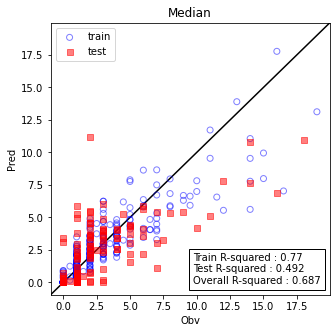

In [62]:
### 베이지안 
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)

from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal
def ngb_cv(learning_rate, n_estimators, silent=True):

      # 모델 정의
    model = NGBRegressor(Dist = Exponential, learning_rate=learning_rate,n_estimators=int(n_estimators), random_state =42)
      # 모델 훈련
    model.fit(x_med_train, y_med_train)

#       # 예측값 출력
    y_pred= model.predict(x_med_test)
#     r2 = r2_score(y_med_test, y_pred)
#     return r2
    temp_xgb_train_predict = model.predict(x_med_train)
    train_r2 = r2_score(y_med_train,temp_xgb_train_predict)
    r2 = r2_score(y_med_test, y_pred)
    score = cross_val_score(model, x_med_train, y_med_train.values.ravel(), cv = 5,scoring='r2')
    cv_score = score.mean()
    if (train_r2 < 0.86) & (train_r2 > 0) & (cv_score > 0):
        return r2
    else:
        return 0.3

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'learning_rate': (0.01, 0.5),
           'n_estimators': (150,250)}
bo=BayesianOptimization(f=ngb_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=5, n_iter=50, acq='ei', xi=0.02)
print(bo.max)

from ngboost import NGBRegressor
ngb_model = NGBRegressor(Dist = Exponential,n_estimators =int(bo.max['params']['n_estimators']), learning_rate =bo.max['params']['learning_rate'],verbose=False, random_state =42)
ngb_model.fit(x_med_train, y_med_train)
score = cross_val_score(ngb_model, x_med_train, y_med_train.values.ravel(), cv = 5,scoring='r2')
cv_score = score.mean()
print(score)
print(cv_score)
ngb_predict = ngb_model.predict(x_med_test)
ngb_train_predict = ngb_model.predict(x_med_train)

make_pred_obv_plot(y_med_test,y_med_train,ngb_predict,ngb_train_predict,'Median')

0.492 test r-squared
0.77 train r-squared
2.3486395667833313 test RMSE
1.5781667699842925 train RMSE


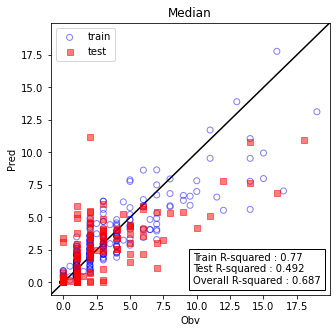

In [60]:
### 베이지안 
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)

from ngboost import NGBRegressor
med_ngb = NGBRegressor(Dist = Exponential,n_estimators =180, learning_rate =0.04705060790701935,verbose=False, random_state =42)
med_ngb.fit(x_med_train, y_med_train)
ngb_predict = med_ngb.predict(x_med_test)
ngb_train_predict = med_ngb.predict(x_med_train)

make_pred_obv_plot(y_med_test,y_med_train,ngb_predict,ngb_train_predict,'Median')

In [61]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)
error_put(med_ngb,x_med_train,x_med_test,y_med_train,y_med_test, med_error_train,med_error_test, med_error_total, 'NGB')

In [62]:
med_error_train

id        RF       XGB           NGB
65   140 -2.913799 -3.688300 -2.433244e+00
13    53 -4.755629 -5.025908 -6.218406e+00
456  638 -0.628047 -0.473452 -6.192788e-01
482  674  1.831857  1.097578  4.249000e-01
417  590 -0.695249 -0.361343  1.657189e+00
..   ...       ...       ...           ...
485  677  0.284691  0.352483  7.484896e-01
520  723 -0.024703 -0.392319 -5.017065e-01
244  381  1.536389  1.396466  1.923801e+00
206  330  0.177569  0.347929  3.337430e-22
131  229  3.154153  0.895900  1.800550e+00

[308 rows x 4 columns]

### smote

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
[iter 0] loss=3.5503 val_loss=0.0000 scale=1.0000 norm=6.5342
|  1        |  0.5835   |  0.1126   |  15.8     |
[iter 0] loss=3.5503 val_loss=0.0000 scale=1.0000 norm=6.5342
|  2        |  0.1428   |  0.05002  |  9.535    |
[iter 0] loss=3.5503 val_loss=0.0000 scale=1.0000 norm=6.5342
|  3        |  0.1084   |  0.07201  |  6.385    |
[iter 0] loss=3.5503 val_loss=0.0000 scale=1.0000 norm=6.5342
|  4        |  0.3326   |  0.07794  |  10.18    |
[iter 0] loss=3.5503 val_loss=0.0000 scale=1.0000 norm=6.5342
|  5        |  0.5339   |  0.1095   |  13.08    |
[iter 0] loss=3.5503 val_loss=0.0000 scale=1.0000 norm=6.5342
|  6        |  0.5614   |  0.1094   |  15.47    |
[iter 0] loss=3.5503 val_loss=0.0000 scale=1.0000 norm=6.5342
|  7        |  0.5742   |  0.2      |  17.36    |
[iter 0] loss=3.5503 val_loss=0.0000 scale=1.0000 norm=6.5342
|  8        |  0.4497   |  0.05     |  20.0     |
[ite

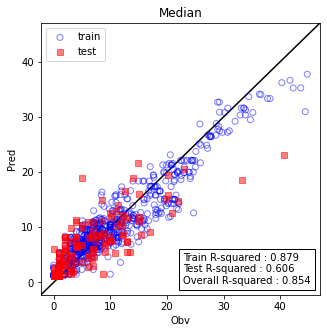

In [172]:
### 베이지안 
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal
def ngb_cv(learning_rate, n_estimators, silent=True):

      # 모델 정의
    model = NGBRegressor(Dist = Normal, learning_rate=learning_rate,n_estimators=int(n_estimators), random_state =42)
      # 모델 훈련
    model.fit(x_train_smote_med, y_train_smote_med)

      # 예측값 출력
    y_pred= model.predict(x_test_smote_med)
    r2 = r2_score(y_test_smote_med, y_pred)
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'learning_rate': (0.05, 0.2),
           'n_estimators': (5,20)}
bo=BayesianOptimization(f=ngb_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=5, n_iter=50, acq='ei', xi=0.02)
print(bo.max)

from ngboost import NGBRegressor
ngb_model = NGBRegressor(Dist = Normal,n_estimators =int(bo.max['params']['n_estimators']), learning_rate =bo.max['params']['learning_rate'],verbose=False, random_state =42)
ngb_model.fit(x_train_smote_med, y_train_smote_med)
ngb_predict = ngb_model.predict(x_test_smote_med)
ngb_train_predict = ngb_model.predict(x_train_smote_med)

make_pred_obv_plot(y_test_smote_med,y_train_smote_med,ngb_predict,ngb_train_predict,'Median')

## 95Q

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  1        |  0.2263   |  0.08923  |  46.02    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  2        |  0.3432   |  0.01002  |  25.12    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  3        |  0.4767   |  0.03788  |  14.62    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  4        |  0.5605   |  0.04539  |  27.28    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  5        |  0.1831   |  0.08539  |  36.94    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  6        |  0.2534   |  0.08965  |  44.26    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  7        |  0.2606   |  0.04885  |  53.91    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  8        |  0.4984   |  0.0152   |  43.52    |
[ite

|  57       |  0.5406   |  0.02915  |  43.46    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  58       |  0.5497   |  0.02947  |  48.1     |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  59       |  0.1207   |  0.1381   |  58.19    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  60       |  0.4254   |  0.01481  |  30.35    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  61       |  0.2349   |  0.1168   |  26.4     |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  62       |  0.1339   |  0.1575   |  19.81    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  63       |  0.2635   |  0.05095  |  47.83    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  64       |  0.5132   |  0.01903  |  43.5     |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm=1.3386
|  65       |  0.494    |  0.0149   |  43.47    |
[iter 0] loss=3.1597 val_loss=0.0000 scale=2.0000 norm

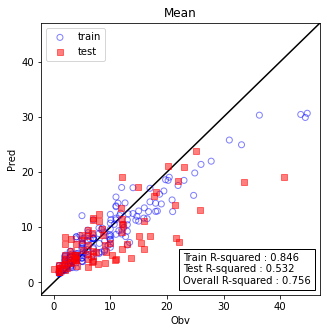

In [53]:

SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)
### 베이지안 
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal
def ngb_cv(learning_rate, n_estimators, silent=True):

      # 모델 정의
    model = NGBRegressor(Dist = Exponential,
                         learning_rate=learning_rate,
                         n_estimators=int(n_estimators),
                         random_state =42)
      # 모델 훈련
    model.fit(x_95q_train, y_95q_train.values.ravel())

      # 예측값 출력
    y_pred= model.predict(x_95q_test)
    r2 = r2_score(y_95q_test, y_pred)
    train_predict = model.predict(x_95q_train)
    r2_train = r2_score(y_95q_train,train_predict)
    if r2_train > 0.86:
        r2 -= 0.3
    else: 
        r2 = r2
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'learning_rate': (0.01, 0.2),
           'n_estimators': (10,60)}
bo=BayesianOptimization(f=ngb_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=10, n_iter=100, acq='ei', xi=0.02)
print(bo.max)

from ngboost import NGBRegressor
ngb_model = NGBRegressor(Dist = Exponential, n_estimators =int(bo.max['params']['n_estimators']), learning_rate =bo.max['params']['learning_rate'],verbose=False, random_state =42)
ngb_model.fit(x_95q_train, y_95q_train)
ngb_predict = ngb_model.predict(x_95q_test)
ngb_train_predict = ngb_model.predict(x_95q_train)

make_pred_obv_plot(y_95q_test,y_95q_train,ngb_predict,ngb_train_predict,'Mean')

0.569 test r-squared
0.846 train r-squared
5.061761891484983 test RMSE
3.1368412415688085 train RMSE


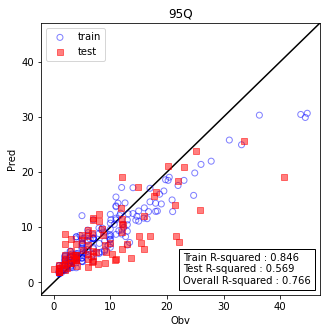

In [63]:
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)


from ngboost import NGBRegressor
q_ngb = NGBRegressor(Dist = Exponential, n_estimators =34, learning_rate =0.05051730901169541,verbose=False, random_state =42)
q_ngb.fit(x_95q_train, y_95q_train)

ngb_predict = q_ngb.predict(x_95q_test)
ngb_train_predict = q_ngb.predict(x_95q_train)

make_pred_obv_plot(y_95q_test,y_95q_train,ngb_predict,ngb_train_predict,'95Q')

In [64]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)

error_put(q_ngb,x_95q_train,x_95q_test,y_95q_train,y_95q_test, q_error_train,q_error_test, q_error_total, 'NGB')

In [65]:
q_error_train

id        RF       XGB       NGB
41   103  3.309114  5.684599  4.475680
562  786  1.192773  0.883528  1.122527
119  217  1.869595  2.950858  3.909985
281  425 -0.381697 -1.056540 -0.199226
523  726  1.596177  1.997796  1.860616
..   ...       ...       ...       ...
240  373  0.554346  0.810940  0.986712
42   104  5.822352  3.911778  4.350647
112  203 -0.291634  0.737559 -0.442621
487  679  1.300893  1.787508  1.011546
192  312 -1.621130 -3.830135 -3.219476

[198 rows x 4 columns]

### smote

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  1        |  0.1125   |  0.1726   |  15.25    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  2        |  0.07     |  0.01004  |  8.14     |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  3        |  0.3093   |  0.06723  |  4.57     |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  4        |  0.5297   |  0.08264  |  8.875    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  5        |  0.5714   |  0.1647   |  12.16    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  6        |  0.1563   |  0.1735   |  14.65    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  7        |  0.5911   |  0.08974  |  17.93    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  8        |  0.3349   |  0.02068  |  14.4     |
[ite

|  57       |  0.09462  |  0.237    |  12.66    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  58       |  0.5749   |  0.1186   |  12.73    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  59       |  0.5729   |  0.163    |  12.82    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  60       |  0.406    |  0.03443  |  11.97    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  61       |  0.5514   |  0.1439   |  13.87    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  62       |  0.56     |  0.1263   |  12.59    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  63       |  0.5945   |  0.09789  |  17.16    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  64       |  0.5405   |  0.217    |  11.19    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  65       |  0.1603   |  0.1241   |  19.96    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm

[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  115      |  0.5887   |  0.07679  |  17.46    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  116      |  0.6048   |  0.08429  |  17.5     |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  117      |  0.5541   |  0.1914   |  9.275    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  118      |  0.5456   |  0.08922  |  9.32     |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  119      |  0.5249   |  0.2017   |  9.419    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  120      | -0.09753  |  0.3228   |  9.333    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  121      |  0.5371   |  0.1017   |  9.457    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  122      |  0.5616   |  0.1428   |  9.236    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  123      |  0.5699   |  0.182    |  9.5

[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  172      |  0.4892   |  0.2331   |  9.038    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  173      |  0.5902   |  0.1458   |  13.77    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  174      |  0.5731   |  0.1119   |  13.77    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  175      |  0.5462   |  0.1314   |  13.77    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  176      |  0.5811   |  0.1148   |  13.79    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  177      |  0.5658   |  0.07262  |  17.48    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  178      |  0.5515   |  0.1436   |  13.79    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  179      |  0.5779   |  0.08952  |  17.95    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  180      |  0.5546   |  0.1219   |  11.

[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  229      |  0.1255   |  0.166    |  14.93    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  230      |  0.2062   |  0.01413  |  12.51    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  231      |  0.5613   |  0.1245   |  12.84    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  232      |  0.5256   |  0.1237   |  8.811    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  233      |  0.5641   |  0.1482   |  9.071    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  234      |  0.5832   |  0.21     |  9.878    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  235      |  0.4709   |  0.2776   |  9.905    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  236      |  0.1348   |  0.01     |  12.93    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  237      |  0.5585   |  0.1437   |  12.

[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  286      |  0.5364   |  0.1946   |  11.89    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  287      |  0.05074  |  0.2575   |  11.82    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  288      |  0.5584   |  0.1654   |  9.199    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  289      |  0.5852   |  0.1543   |  11.92    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  290      |  0.5491   |  0.1227   |  11.86    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  291      |  0.4496   |  0.3034   |  5.799    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  292      |  0.4714   |  0.04656  |  11.79    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  293      |  0.5485   |  0.132    |  9.739    |
[iter 0] loss=3.4264 val_loss=0.0000 scale=1.0000 norm=0.5316
|  294      |  0.5636   |  0.1422   |  12.

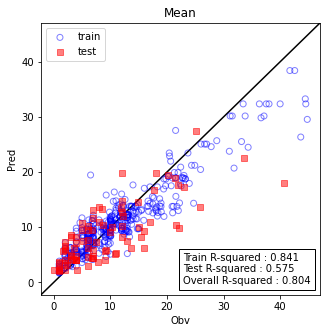

In [58]:
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)

### 베이지안 
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal

def ngb_cv(learning_rate, n_estimators, silent=True):

      # 모델 정의
    model = NGBRegressor(Dist = Exponential, learning_rate=learning_rate,n_estimators=int(n_estimators),
                         random_state =42)#)
      # 모델 훈련
    model.fit(x_train_smote, y_train_smote)

      # 예측값 출력
    y_pred= model.predict(x_test_smote)
    r2 = r2_score(y_test_smote, y_pred)
    
    predict_train = model.predict(x_train_smote)
    r2_train = r2_score(y_train_smote, predict_train)
    
    if r2_train > 0.86:
        r2 = r2-0.4
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'learning_rate': (0.01, 0.4),
           'n_estimators': (3,20)}
bo=BayesianOptimization(f=ngb_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=20, n_iter=300, acq='ei', xi=0.01)
print(bo.max)

from ngboost import NGBRegressor
ngb_model = NGBRegressor(Dist = Exponential,n_estimators =int(bo.max['params']['n_estimators']), learning_rate =bo.max['params']['learning_rate'],verbose=False, random_state =42, col_sample = 0.8)
score = cross_val_score(ngb_model, x_train_smote, y_train_smote.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
ngb_model.fit(x_train_smote, y_train_smote)
ngb_predict = ngb_model.predict(x_test_smote)
ngb_train_predict = ngb_model.predict(x_train_smote)

make_pred_obv_plot(y_test_smote,y_train_smote,ngb_predict,ngb_train_predict,'Mean')

6.16e-01 test r-squared
0.838 train r-squared
4.777689945134276 test RMSE
3.3355556990245896 train RMSE


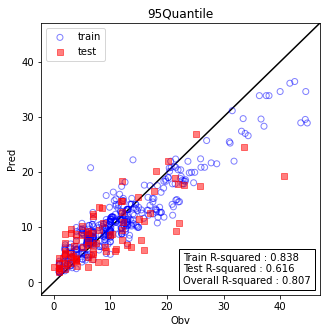

In [76]:
# SEED=42
# import random
# import os
# import tensorflow as tf
# def seed_everything(seed: int = 42):
#     random.seed(seed)
#     np.random.seed(seed)
#     os.environ["PYTHONHASHSEED"] = str(seed)
#     tf.random.set_seed(seed)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'

# seed_everything(42)


from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal
smote_ngb = NGBRegressor(Dist = Exponential,n_estimators =17, learning_rate =0.09906979830862747,verbose=False, random_state =42)
smote_ngb.fit(x_train_smote, y_train_smote)
ngb_predict = smote_ngb.predict(x_test_smote)
ngb_train_predict = smote_ngb.predict(x_train_smote)

make_pred_obv_plot(y_test_smote,y_train_smote,ngb_predict,ngb_train_predict,'95Quantile')

Translating model_ouput="raw" to model_output=0 for the 0-th parameter in the distribution. Use model_output=0 directly to avoid this warning.


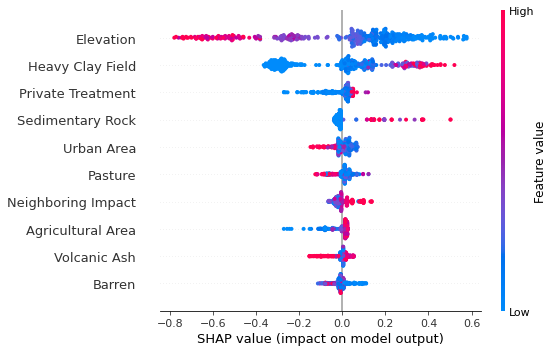

In [77]:
shap_model(smote_ngb,x_train_smote)

In [64]:
x_train_smote.columns=['Urban Area', 'Agricultural Area', 'Forest', 'Pasture', 'Barren',
       'Basic Rock', 'Sedimentary Rock', 'Volcanic Ash', 'Normal Paddy',
       'Immatured Paddy', 'Normal Field', 'Forest Land 2', 'Sandy Field',
       'Heavy Clay Field', 'Forest Land 3', 'Private Treatment',
       'Artificial Recharge Well', 'Detention Pond', 'Geothermal Facility',
       'Specified Waste Discharge Facility',
       'Livestock Facility', 'Soil Contamination Facility',
       'Wastewater Discharge Facility', 'Elevation', 'Neighboring Impact']

In [69]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)

error_put(smote_ngb,x_95q_train,x_95q_test,y_95q_train,y_95q_test, smote_error_train,smote_error_test, smote_error_total, 'NGB')

In [221]:
smote_error_train

id        RF       XGB       NGB
41   103  8.471294  7.243557  3.773863
562  786  2.481166  3.229555  3.903791
119  217  4.443850  3.789663  5.532808
281  425 -0.229391 -0.767479  0.108824
523  726  2.176482  3.000296  2.687463
..   ...       ...       ...       ...
240  373  3.289568  3.553000  3.082348
42   104  9.006672  6.408502  6.076885
112  203  0.163601  0.838310 -0.174384
487  679  1.538700  1.801277  2.547287
192  312 -1.034741 -1.916119 -2.042623

[198 rows x 4 columns]

In [222]:
mean_error_train

id        RF       XGB       NGB       SVM       ANN
532  741 -0.087798 -1.170446 -0.216125 -0.223806 -1.093751
361  520  0.395336 -1.623317 -0.004176 -0.034882 -0.885859
443  620  0.086957  0.073772 -0.020708  0.100271  0.379853
259  396 -1.596307 -3.751659 -1.975961 -1.350872 -1.304920
448  625  0.893159 -1.716116  0.792785 -0.074665 -0.347067
..   ...       ...       ...       ...       ...       ...
93   178 -0.084045 -0.207877 -0.155230  0.609337  0.350921
330  485  1.335708 -1.442778  0.348267  0.099704 -0.507158
487  679  0.760018 -0.039842  0.316469  0.099481  0.667065
131  229  0.957979 -2.262167  0.006216  0.100159 -0.312449
559  783 -0.355496 -2.094480 -0.775778 -0.406547 -0.881081

[308 rows x 6 columns]

# ANN

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K
from sklearn.metrics import r2_score

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train_smote)

x_95q_train_scaled = pd.DataFrame(scaler.transform(x_train_smote), columns = x_train_smote.columns)
x_95q_test_scaled = pd.DataFrame(scaler.transform(x_test_smote), columns = x_test_smote.columns)

## mean

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                832       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

11/11 [==============================] - 0s 6ms/step - loss: 2.2454
Epoch 186/200
11/11 [==============================] - 0s 6ms/step - loss: 2.7212
Epoch 187/200
11/11 [==============================] - 0s 6ms/step - loss: 2.4003
Epoch 188/200
11/11 [==============================] - 0s 6ms/step - loss: 2.5191
Epoch 189/200
11/11 [==============================] - 0s 7ms/step - loss: 2.0338
Epoch 190/200
11/11 [==============================] - 0s 6ms/step - loss: 2.4490
Epoch 191/200
11/11 [==============================] - 0s 9ms/step - loss: 2.3437
Epoch 192/200
11/11 [==============================] - 0s 7ms/step - loss: 2.4003
Epoch 193/200
11/11 [==============================] - 0s 7ms/step - loss: 2.4224
Epoch 194/200
11/11 [==============================] - 0s 5ms/step - loss: 2.2515
Epoch 195/200
11/11 [==============================] - 0s 4ms/step - loss: 3.1294
Epoch 196/200
11/11 [==============================] - 0s 4ms/step - loss: 2.4578
Epoch 197/200
11/11 [=========

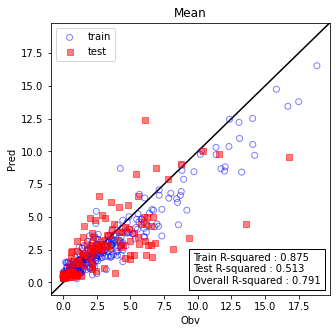

In [89]:
import tensorflow as tf
tf.random.set_seed(2)

def ann_model(x,y,z):
    with tf.device("/gpu:0"):
        
        model = Sequential()
        model.add(Dense(x,input_dim = x_train_scaled.shape[1], activation = 'relu'))
        model.add(Dropout(0.2))

        model.add(Dense(y,activation = 'relu'))
        model.add(Dropout(0.2))

        model.add(Dense(z,activation = 'relu'))
        model.add(Dropout(0.2))
        
#         model.add(Dense(w,activation = 'relu'))
#         model.add(Dropout(0.3))

        model.add(Dense(1))
        model.summary()
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        history = model.fit(x_train_scaled, y_train, epochs = 200, batch_size = 30)
    #early_stop = EarlyStopping(monitor = 'val_loss', patience = 20)
    # check = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 0, save_best_only =True)
    return model
#model = ann_model(x= 10*bo.max['params']['x'],y=10*bo.max['params']['y'],z=10*bo.max['params']['z'])
mean_ann = ann_model(x= 32,y=32,z=64)
# score = cross_val_score(model, x_train_scaled, y_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
# cv_score = score.mean()
# print(score,'cv - score')
# print(cv_score, 'cv mean - score')
#history = model.fit(x_train_scaled,y_train, epochs = 700, batch_size = 20)

ann_predict = mean_ann.predict(x_test_scaled)
ann_train_predict = mean_ann.predict(x_train_scaled)

make_pred_obv_plot(y_test,y_train,ann_predict,ann_train_predict,'Mean')


In [91]:
mean_error_test['ANN'] =(mean_ann.predict(x_test_scaled).ravel() - y_test)
mean_error_train['ANN'] =(mean_ann.predict(x_train_scaled).ravel() - y_train)

## median

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                416       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 

11/11 [==============================] - 0s 4ms/step - loss: 5.5225
Epoch 189/500
11/11 [==============================] - 0s 4ms/step - loss: 4.4394
Epoch 190/500
11/11 [==============================] - 0s 4ms/step - loss: 4.5349
Epoch 191/500
11/11 [==============================] - 0s 4ms/step - loss: 4.9862
Epoch 192/500
11/11 [==============================] - 0s 4ms/step - loss: 4.4958
Epoch 193/500
11/11 [==============================] - 0s 4ms/step - loss: 4.5892
Epoch 194/500
11/11 [==============================] - 0s 4ms/step - loss: 5.2045
Epoch 195/500
11/11 [==============================] - 0s 4ms/step - loss: 4.5178
Epoch 196/500
11/11 [==============================] - 0s 4ms/step - loss: 4.3468
Epoch 197/500
11/11 [==============================] - 0s 4ms/step - loss: 4.6881
Epoch 198/500
11/11 [==============================] - 0s 4ms/step - loss: 4.7422
Epoch 199/500
11/11 [==============================] - 0s 4ms/step - loss: 4.2520
Epoch 200/500
11/11 [=========

11/11 [==============================] - 0s 4ms/step - loss: 4.3855
Epoch 289/500
11/11 [==============================] - 0s 4ms/step - loss: 4.2989
Epoch 290/500
11/11 [==============================] - 0s 4ms/step - loss: 4.9482
Epoch 291/500
11/11 [==============================] - 0s 4ms/step - loss: 4.0507
Epoch 292/500
11/11 [==============================] - 0s 4ms/step - loss: 4.5382
Epoch 293/500
11/11 [==============================] - 0s 4ms/step - loss: 4.1844
Epoch 294/500
11/11 [==============================] - 0s 4ms/step - loss: 4.1173
Epoch 295/500
11/11 [==============================] - 0s 4ms/step - loss: 4.7569
Epoch 296/500
11/11 [==============================] - 0s 4ms/step - loss: 4.4596
Epoch 297/500
11/11 [==============================] - 0s 4ms/step - loss: 4.4353
Epoch 298/500
11/11 [==============================] - 0s 4ms/step - loss: 4.1253
Epoch 299/500
11/11 [==============================] - 0s 4ms/step - loss: 4.2416
Epoch 300/500
11/11 [=========

11/11 [==============================] - 0s 5ms/step - loss: 3.1837
Epoch 389/500
11/11 [==============================] - 0s 5ms/step - loss: 2.9626
Epoch 390/500
11/11 [==============================] - 0s 5ms/step - loss: 3.5406
Epoch 391/500
11/11 [==============================] - 0s 5ms/step - loss: 3.2635
Epoch 392/500
11/11 [==============================] - 0s 5ms/step - loss: 3.6241
Epoch 393/500
11/11 [==============================] - 0s 5ms/step - loss: 3.6931
Epoch 394/500
11/11 [==============================] - 0s 4ms/step - loss: 3.9352
Epoch 395/500
11/11 [==============================] - 0s 3ms/step - loss: 3.7363
Epoch 396/500
11/11 [==============================] - 0s 3ms/step - loss: 3.4428
Epoch 397/500
11/11 [==============================] - 0s 3ms/step - loss: 3.4072
Epoch 398/500
11/11 [==============================] - 0s 3ms/step - loss: 4.7110
Epoch 399/500
11/11 [==============================] - 0s 3ms/step - loss: 3.3267
Epoch 400/500
11/11 [=========

11/11 [==============================] - 0s 4ms/step - loss: 3.3379
Epoch 489/500
11/11 [==============================] - 0s 4ms/step - loss: 3.4805
Epoch 490/500
11/11 [==============================] - 0s 4ms/step - loss: 3.1266
Epoch 491/500
11/11 [==============================] - 0s 4ms/step - loss: 3.2782
Epoch 492/500
11/11 [==============================] - 0s 5ms/step - loss: 3.8643
Epoch 493/500
11/11 [==============================] - 0s 5ms/step - loss: 3.5439
Epoch 494/500
11/11 [==============================] - 0s 4ms/step - loss: 3.2882
Epoch 495/500
11/11 [==============================] - 0s 4ms/step - loss: 3.5746
Epoch 496/500
11/11 [==============================] - 0s 4ms/step - loss: 3.8438
Epoch 497/500
11/11 [==============================] - 0s 4ms/step - loss: 3.5538
Epoch 498/500
11/11 [==============================] - 0s 4ms/step - loss: 3.9569
Epoch 499/500
11/11 [==============================] - 0s 4ms/step - loss: 2.9080
Epoch 500/500
11/11 [=========

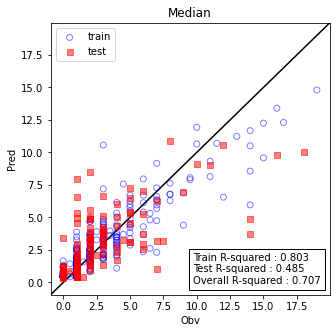

In [92]:
import tensorflow as tf
tf.random.set_seed(2)

def ann_model(x,y,z):
    with tf.device("/gpu:0"):
        
        model = Sequential()
        model.add(Dense(x,input_dim = x_med_train_scaled.shape[1], activation = 'relu'))
        model.add(Dropout(0.2))

        model.add(Dense(y,activation = 'relu'))
        model.add(Dropout(0.2))

 #       model.add(Dense(z,activation = 'relu'))
 #       model.add(Dropout(0.35))
        
#         model.add(Dense(w,activation = 'relu'))
#         model.add(Dropout(0.3))

        model.add(Dense(1))
        model.summary()
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        history = model.fit(x_med_train_scaled, y_med_train, epochs =500, batch_size = 30)
    #early_stop = EarlyStopping(monitor = 'val_loss', patience = 20)
    # check = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 0, save_best_only =True)
    return model
#model = ann_model(x= 10*bo.max['params']['x'],y=10*bo.max['params']['y'],z=10*bo.max['params']['z'])
med_ann = ann_model(x= 16,y=32,z=16)
# score = cross_val_score(model, x_train_scaled, y_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
# cv_score = score.mean()
# print(score,'cv - score')
# print(cv_score, 'cv mean - score')
#history = model.fit(x_train_scaled,y_train, epochs = 700, batch_size = 20)

ann_predict = med_ann.predict(x_med_test_scaled)
ann_train_predict = med_ann.predict(x_med_train_scaled)

make_pred_obv_plot(y_med_test,y_med_train,ann_predict,ann_train_predict,'Median')


In [93]:
med_error_test['ANN'] =(med_ann.predict(x_med_test_scaled).ravel() - y_med_test)
med_error_train['ANN'] =(med_ann.predict(x_med_train_scaled).ravel() - y_med_train)

In [239]:
med_error_test

id        RF       XGB       NGB       SVM       ANN
66   141 -0.309980 -0.431428 -1.927936 -0.367947  0.097656
360  519 -0.245087 -0.788438 -0.493429 -0.267118  0.086110
538  747  2.969795  2.762059  3.103515  0.938369  1.162530
92   177  1.874486 -0.328572 -0.208663  0.959608 -1.503622
495  687  0.713857  0.560447  0.128976  0.985511 -0.237917
..   ...       ...       ...       ...       ...       ...
447  624  2.105617  1.002319  0.850113  3.183746  1.066389
227  360  1.894678 -0.649000  0.606809 -0.299296 -1.029798
260  397  0.422004  0.158186  0.301548 -0.626200 -1.260239
472  659  0.115873  0.491225  0.113318  0.576912  0.278730
433  610  1.797344  3.276834  1.727022 -0.399013 -0.028018

[132 rows x 6 columns]

## 95q

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                1664      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                

7/7 [==============================] - 0s 7ms/step - loss: 19.6782
Epoch 188/300
7/7 [==============================] - 0s 6ms/step - loss: 16.0856
Epoch 189/300
7/7 [==============================] - 0s 6ms/step - loss: 19.7445
Epoch 190/300
7/7 [==============================] - 0s 7ms/step - loss: 19.3887
Epoch 191/300
7/7 [==============================] - 0s 7ms/step - loss: 18.5997
Epoch 192/300
7/7 [==============================] - 0s 6ms/step - loss: 18.8921
Epoch 193/300
7/7 [==============================] - 0s 7ms/step - loss: 14.7292
Epoch 194/300
7/7 [==============================] - 0s 6ms/step - loss: 16.5461
Epoch 195/300
7/7 [==============================] - 0s 7ms/step - loss: 19.2161
Epoch 196/300
7/7 [==============================] - 0s 7ms/step - loss: 16.5959
Epoch 197/300
7/7 [==============================] - 0s 7ms/step - loss: 16.3869
Epoch 198/300
7/7 [==============================] - 0s 7ms/step - loss: 18.9907
Epoch 199/300
7/7 [=======================

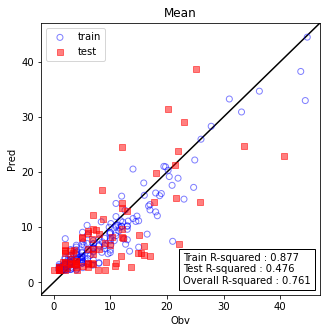

In [94]:
import tensorflow as tf
tf.random.set_seed(2)

def ann_model(x,y,z):
    with tf.device("/gpu:0"):
        
        model = Sequential()
        model.add(Dense(x,input_dim = x_95q_train_scaled.shape[1], activation = 'tanh'))
        model.add(Dropout(0.3))

        model.add(Dense(y,activation = 'relu'))
        model.add(Dropout(0.3))

        model.add(Dense(z,activation = 'relu'))
        model.add(Dropout(0.3))
        
#         model.add(Dense(w,activation = 'relu'))
#         model.add(Dropout(0.3))

        model.add(Dense(1))
        model.summary()
        model.compile(optimizer='RMSprop', loss='mean_squared_error')
        
        history = model.fit(x_95q_train_scaled, y_95q_train, epochs = 300, batch_size = 30)
    #early_stop = EarlyStopping(monitor = 'val_loss', patience = 20)
    # check = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 0, save_best_only =True)
    return model
#model = ann_model(x= 10*bo.max['params']['x'],y=10*bo.max['params']['y'],z=10*bo.max['params']['z'])
q_ann = ann_model(x= 64,y=32,z=32)
# score = cross_val_score(model, x_train_scaled, y_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
# cv_score = score.mean()
# print(score,'cv - score')
# print(cv_score, 'cv mean - score')
#history = model.fit(x_train_scaled,y_train, epochs = 700, batch_size = 20)

ann_predict = q_ann.predict(x_95q_test_scaled)
ann_train_predict = q_ann.predict(x_95q_train_scaled)

make_pred_obv_plot(y_95q_test,y_95q_train,ann_predict,ann_train_predict,'Mean')


In [95]:
q_error_test['ANN'] =(q_ann.predict(x_95q_test_scaled).ravel() - y_95q_test)
q_error_train['ANN'] =(q_ann.predict(x_95q_train_scaled).ravel() - y_95q_train)

In [343]:
scaler = StandardScaler()
scaler.fit(x_95q_train)

x_95q_train_scaled = pd.DataFrame(scaler.transform(x_95q_train), columns = x_95q_train.columns)
x_95q_test_scaled = pd.DataFrame(scaler.transform(x_95q_test), columns = x_95q_test.columns)

### smote

In [36]:
scaler = StandardScaler()
scaler.fit(x_train_smote)

x_95q_train_scaled = pd.DataFrame(scaler.transform(x_train_smote), columns = x_train_smote.columns)
x_95q_test_scaled = pd.DataFrame(scaler.transform(x_test_smote), columns = x_test_smote.columns)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 32)                832       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                544       
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                

15/15 [==============================] - 0s 7ms/step - loss: 22.6965
Epoch 184/300
15/15 [==============================] - 0s 7ms/step - loss: 20.0763
Epoch 185/300
15/15 [==============================] - 0s 7ms/step - loss: 19.2824
Epoch 186/300
15/15 [==============================] - 0s 7ms/step - loss: 24.0324
Epoch 187/300
15/15 [==============================] - 0s 7ms/step - loss: 20.0759
Epoch 188/300
15/15 [==============================] - 0s 7ms/step - loss: 21.0817
Epoch 189/300
15/15 [==============================] - 0s 7ms/step - loss: 17.3708
Epoch 190/300
15/15 [==============================] - 0s 7ms/step - loss: 23.8532
Epoch 191/300
15/15 [==============================] - 0s 7ms/step - loss: 18.8675
Epoch 192/300
15/15 [==============================] - 0s 7ms/step - loss: 19.5096
Epoch 193/300
15/15 [==============================] - 0s 7ms/step - loss: 23.6535
Epoch 194/300
15/15 [==============================] - 0s 7ms/step - loss: 18.5672
Epoch 195/300
15/1

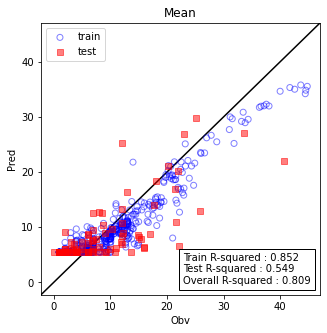

In [96]:
import tensorflow as tf
tf.random.set_seed(2)

def ann_model(x,y,z):
    with tf.device("/gpu:0"):
        
        model = Sequential()
        model.add(Dense(x,input_dim = x_95q_train_scaled.shape[1], activation = 'tanh'))
        model.add(Dropout(0.3))

        model.add(Dense(y,activation = 'relu'))
        model.add(Dropout(0.3))

        model.add(Dense(z,activation = 'relu'))
        model.add(Dropout(0.3))
        
#         model.add(Dense(w,activation = 'relu'))
#         model.add(Dropout(0.3))

        model.add(Dense(1))
        model.summary()
        model.compile(optimizer='RMSprop', loss='mean_squared_error')
        
        history = model.fit(x_95q_train_scaled_smote, y_train_smote, epochs = 300, batch_size = 30)
    #early_stop = EarlyStopping(monitor = 'val_loss', patience = 20)
    # check = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 0, save_best_only =True)
    return model
#model = ann_model(x= 10*bo.max['params']['x'],y=10*bo.max['params']['y'],z=10*bo.max['params']['z'])
smote_ann = ann_model(x= 32,y=16,z=32)
# score = cross_val_score(model, x_train_scaled, y_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
# cv_score = score.mean()
# print(score,'cv - score')
# print(cv_score, 'cv mean - score')
#history = model.fit(x_train_scaled,y_train, epochs = 700, batch_size = 20)

ann_predict = smote_ann.predict(x_95q_test_scaled_smote)
ann_train_predict = smote_ann.predict(x_95q_train_scaled_smote)

make_pred_obv_plot(y_test_smote,y_train_smote,ann_predict,ann_train_predict,'Mean')


In [ ]:
x_95q_train_scaled_smote = pd.DataFrame(scaler.transform(x_train_smote), columns = x_train_smote.columns)
x_95q_test_scaled_smote

0.604 test r-squared
0.873 train r-squared
4.854875484307132 test RMSE
2.955002291763831 train RMSE


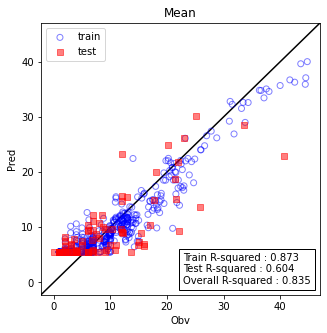

In [38]:
make_pred_obv_plot(y_test_smote,y_train_smote,ann_predict,ann_train_predict,'Mean')


In [98]:
smote_error_test['ANN'] =(smote_ann.predict(x_95q_test_scaled).ravel() - y_95q_test)
smote_error_train['ANN'] =(smote_ann.predict(x_95q_train_scaled).ravel() - y_95q_train)

In [99]:
smote_error_train

id         RF       XGB       NGB       SVM       ANN
41   103  10.390720  7.243557  4.129963  9.655417  4.160995
562  786   2.956411  3.229555  3.343402  5.939915  3.093848
119  217   4.837001  3.789663  4.420650  4.332371  3.488006
281  425  -0.468045 -0.767479 -0.622761  0.764088 -0.010007
523  726   2.152843  3.000296  1.598312  4.292854  3.903832
..   ...        ...       ...       ...       ...       ...
240  373   3.005691  3.553000  2.577093  0.127659  2.468835
42   104   9.916376  6.408502  4.508382  2.113307  0.981153
112  203   0.076214  0.838310  0.157547  2.598758  1.521166
487  679   1.547169  1.801277  1.529278  3.254866  4.619309
192  312  -0.983506 -1.916119 -0.340601  2.364676  2.145222

[198 rows x 6 columns]

In [27]:
scaler = StandardScaler()
scaler.fit(x_train_smote)

x_95q_train_scaled = pd.DataFrame(scaler.transform(x_train_smote), columns = x_train_smote.columns)
x_95q_test_scaled = pd.DataFrame(scaler.transform(x_test_smote), columns = x_test_smote.columns)

# SVM

In [71]:
from sklearn.svm import SVR

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.4636   |  0.8923   |  0.7483   |
|  2        |  0.4715   |  0.1002   |  0.3721   |
|  3        |  0.4688   |  0.3788   |  0.1831   |
|  4        |  0.4689   |  0.4539   |  0.411    |
|  5        |  0.464    |  0.8539   |  0.5849   |
|  6        |  0.4643   |  1.995    |  0.1225   |
|  7        |  0.4715   |  0.1036   |  0.9864   |
|  8        |  0.4644   |  1.991    |  0.9923   |
|  9        |  0.4629   |  1.341    |  0.1006   |
|  10       |  0.4632   |  1.458    |  0.9992   |
|  11       |  0.4689   |  0.4532   |  0.9994   |
|  12       |  0.4643   |  1.738    |  0.5412   |
|  13       |  0.4713   |  0.106    |  0.116    |
|  14       |  0.4643   |  0.8359   |  0.1003   |
|  15       |  0.4713   |  0.1049   |  0.7158   |
|  16       |  0.4644   |  1.999    |  0.5877   |
|  17       |  0.4629   |  1.298    |  0.5479   |
|  18       |  0.4692   |  0.4628   |  0.7061   |


|  102      |  0.4643   |  1.805    |  0.8931   |
|  103      |  0.4715   |  0.1015   |  0.4616   |
|  104      |  0.4643   |  1.87     |  0.3605   |
|  105      |  0.4643   |  1.999    |  0.7063   |
{'target': 0.4714583064525436, 'params': {'C': 0.10058768624530988, 'gamma': 0.5379821729826095}}
[0.27584958 0.47832327 0.57366086 0.27703968 0.2927625 ] cv - score
0.3795271771708646 cv mean - score
0.471 test r-squared
0.433 train r-squared
2.086393490364112 test RMSE
2.576340047602554 train RMSE


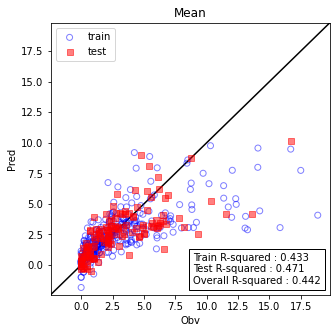

In [144]:
### 베이지안 

def svr_cv( C, gamma):

      # 모델 정의
    model = SVR(kernel = 'linear' , C = C, gamma = gamma)
      # 모델 훈련
    model.fit(x_train_scaled, y_train)

      # 예측값 출력
    y_pred= model.predict(x_test_scaled)
    r2 = r2_score(y_test, y_pred)
    
    predict_train = model.predict(x_train_scaled)
    r2_train = r2_score(y_train, predict_train)
    
#     if r2_train > 0.86:
#         r2 = r2-0.4
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'C': (0.1,2 ),
           'gamma': (0.1,1)}
bo=BayesianOptimization(f=svr_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=5, n_iter=100, acq='ei', xi=0.01)
print(bo.max)

svr_model = SVR(kernel= 'linear', C =(bo.max['params']['C']), gamma =bo.max['params']['gamma'])
score = cross_val_score(svr_model, x_train_scaled, y_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
svr_model.fit(x_train_scaled, y_train)
svr_predict = svr_model.predict(x_test_scaled)
svr_train_predict = svr_model.predict(x_train_scaled)

make_pred_obv_plot(y_test,y_train,svr_predict,svr_train_predict,'Mean')

0.473 test r-squared
0.705 train r-squared
2.0829151263691954 test RMSE
1.8598842354914713 train RMSE


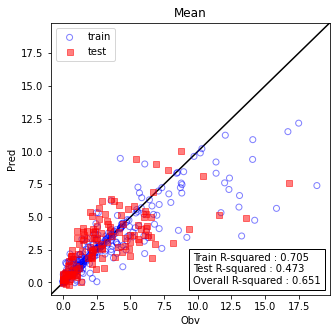

In [72]:
mean_svr = SVR(kernel= 'rbf', C =5, gamma =0.04)
# score = cross_val_score(svr_model, x_train_scaled, y_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
# cv_score = score.mean()
# print(score,'cv - score')
# print(cv_score, 'cv mean - score')
mean_svr.fit(x_train_scaled, y_train)
svr_predict = mean_svr.predict(x_test_scaled)
svr_train_predict = mean_svr.predict(x_train_scaled)

make_pred_obv_plot(y_test,y_train,svr_predict,svr_train_predict,'Mean')

In [74]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)

error_put(mean_svr,x_train_scaled,x_test_scaled,y_train,y_test, mean_error_train,mean_error_test, mean_error_total, 'SVM')

In [75]:
mean_error_train

id        RF       XGB       NGB       SVM
532  741 -0.116695 -1.170446 -0.724328 -0.223806
361  520 -0.010804 -1.623317 -0.116473 -0.034882
443  620  0.030556  0.073772  0.006732  0.100271
259  396 -1.050796 -3.751659 -2.373223 -1.350872
448  625  0.913962 -1.716116  1.139819 -0.074665
..   ...       ...       ...       ...       ...
93   178  0.072300 -0.207877  0.080321  0.609337
330  485  0.485132 -1.442778  0.605319  0.099704
487  679  0.618506 -0.039842  0.570403  0.099481
131  229  0.103516 -2.262167  1.408810  0.100159
559  783 -0.198058 -2.094480 -0.733053 -0.406547

[308 rows x 5 columns]

## median

[0.21564453 0.28508549 0.17994857 0.40903231 0.26658353] cv - score
0.27125888463414316 cv mean - score
0.355 test r-squared
0.53 train r-squared
2.6478259904520662 test RMSE
2.2556740201386405 train RMSE


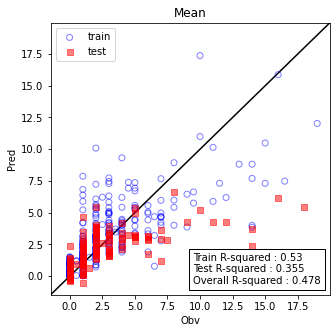

In [610]:
svr_model = SVR(kernel= 'rbf',C = 5 , gamma = 0.01)
score = cross_val_score(svr_model, x_med_train_scaled, y_med_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
svr_model.fit(x_med_train_scaled, y_med_train)
svr_predict = svr_model.predict(x_med_test_scaled)
svr_train_predict = ngb_model.predict(x_med_train_scaled)

make_pred_obv_plot(y_med_test,y_med_train,svr_predict,svr_train_predict,'Mean')

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        | -0.3414   |  16.26    |  2.161    |
|  2        | -0.214    |  10.0     |  0.907    |
|  3        | -0.03584  |  12.2     |  0.277    |
|  4        | -0.2345   |  12.79    |  1.037    |
|  5        | -0.3052   |  15.95    |  1.616    |
|  6        | -0.03004  |  11.91    |  1e-05    |
|  7        | -0.1184   |  11.59    |  0.5284   |
|  8        |  0.3991   |  12.68    |  0.01955  |
|  9        | -0.3475   |  11.29    |  2.276    |
|  10       | -0.02921  |  12.89    |  1e-05    |
|  11       |  0.436    |  12.63    |  0.05429  |
|  12       | -0.0295   |  12.55    |  1e-05    |
|  13       |  0.4372   |  12.7     |  0.04466  |
|  14       | -0.3387   |  18.3     |  2.106    |
|  15       | -0.2621   |  12.23    |  1.22     |
|  16       | -0.0139   |  12.7     |  0.1483   |
|  17       |  0.3528   |  12.89    |  0.008513 |
|  18       |  0.3027   |  11.92    |  0.004224 |


|  101      |  0.4365   |  12.98    |  0.04024  |
|  102      | -0.116    |  24.82    |  0.4751   |
|  103      |  0.4005   |  12.9     |  0.01976  |
|  104      |  0.4373   |  12.91    |  0.04465  |
|  105      |  0.4181   |  12.78    |  0.02635  |
{'target': 0.4391689119738599, 'params': {'C': 12.988953350827202, 'gamma': 0.04682538814660427}}
[ 0.10804877  0.28899642  0.26118881  0.04288644 -0.00349896] cv - score
0.1395242968662082 cv mean - score
0.439 test r-squared
0.742 train r-squared
2.4689370934755765 test RMSE
1.6716664544415654 train RMSE


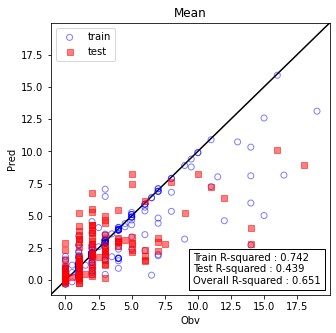

In [20]:
### 베이지안 

def svr_cv( C, gamma):

      # 모델 정의
    model = SVR(kernel = 'rbf' , C = C, gamma = gamma)
      # 모델 훈련
    model.fit(x_med_train_scaled, y_med_train)

      # 예측값 출력
    y_pred= model.predict(x_med_test_scaled)
    r2 = r2_score(y_med_test, y_pred)
    
    predict_train = model.predict(x_med_train_scaled)
    r2_train = r2_score(y_med_train, predict_train)
    
    if r2_train > 0.86:
        r2 = r2-0.4
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'C': (10,25 ),
           'gamma': (0.00001,3) }
bo=BayesianOptimization(f=svr_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=5, n_iter=100, acq='ei', xi=0.03)
print(bo.max)

svr_model = SVR(kernel= 'rbf', C =(bo.max['params']['C']), gamma =bo.max['params']['gamma'])
score = cross_val_score(svr_model, x_med_train_scaled, y_med_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
svr_model.fit(x_med_train_scaled, y_med_train)
svr_predict = svr_model.predict(x_med_test_scaled)
svr_train_predict = svr_model.predict(x_med_train_scaled)

make_pred_obv_plot(y_med_test,y_med_train,svr_predict,svr_train_predict,'Mean')

0.456 test r-squared
0.826 train r-squared
2.43116194590105 test RMSE
1.3716112084486898 train RMSE


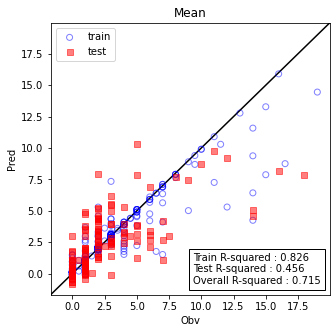

In [76]:
med_svr = SVR(kernel= 'rbf', C =12.988953350827202, gamma =0.04682538814660427)
med_svr.fit(x_med_train_scaled, y_med_train)
svr_predict = med_svr.predict(x_med_test_scaled)
svr_train_predict = med_svr.predict(x_med_train_scaled)

make_pred_obv_plot(y_med_test,y_med_train,svr_predict,svr_train_predict,'Mean')

In [77]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)

error_put(med_svr,x_med_train_scaled,x_med_test_scaled,y_med_train,y_med_test, med_error_train,med_error_test, med_error_total, 'SVM')

## 95q

[0.25953248 0.04100625 0.11431265 0.10825975 0.15538077] cv - score
0.1356983811795071 cv mean - score
0.18 test r-squared
0.271 train r-squared
6.987085333010845 test RMSE
6.819974780258075 train RMSE


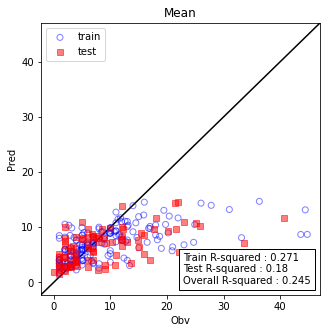

In [36]:
svr_model = SVR(kernel = 'rbf' , degree = 20)#,C = 1 , gamma = 'scale')
score = cross_val_score(svr_model, x_95q_train_scaled, y_95q_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
svr_model.fit(x_95q_train_scaled, y_95q_train)
svr_predict = svr_model.predict(x_95q_test_scaled)
svr_train_predict = svr_model.predict(x_95q_train_scaled)

make_pred_obv_plot(y_95q_test,y_95q_train,svr_predict,svr_train_predict,'Mean')

In [ ]:
svr_model = SVR(kernel= 'rbf',C = 4 , gamma = 'scale')
score = cross_val_score(svr_model, x_train_scaled, y_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
svr_model.fit(x_train_scaled, y_train)
svr_predict = svr_model.predict(x_test_scaled)
svr_train_predict = ngb_model.predict(x_train_scaled)

make_pred_obv_plot(y_test,y_train,svr_predict,svr_train_predict,'Mean')

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        | -0.3062   |  26.68    |  0.7206   |
|  2        |  0.1768   |  10.0     |  0.303    |
|  3        |  0.3483   |  15.87    |  0.09325  |
|  4        | -0.2283   |  17.45    |  0.3462   |
|  5        | -0.2726   |  25.87    |  0.5393   |
|  6        |  0.3866   |  15.38    |  0.0142   |
|  7        | -0.3564   |  15.11    |  1.0      |
|  8        |  0.2398   |  15.61    |  0.001    |
|  9        |  0.3362   |  15.89    |  0.1008   |
|  10       |  0.3865   |  15.16    |  0.01442  |
|  11       | -0.1658   |  15.32    |  0.2      |
|  12       |  0.238    |  15.27    |  0.001    |
|  13       |  0.4195   |  15.06    |  0.05684  |
|  14       | -0.3008   |  32.13    |  0.7023   |
|  15       | -0.2491   |  15.94    |  0.4073   |
|  16       |  0.2706   |  15.0     |  0.001779 |
|  17       |  0.421    |  15.05    |  0.05612  |
|  18       |  0.2728   |  14.97    |  0.1464   |


|  100      |  0.4138   |  12.24    |  0.0538   |
|  101      |  0.3802   |  38.22    |  0.002554 |
|  102      | -0.109    |  38.22    |  0.1391   |
|  103      |  0.4671   |  38.38    |  0.02559  |
|  104      | -0.0116   |  38.54    |  0.06661  |
|  105      |  0.3927   |  38.36    |  0.003957 |
{'target': 0.46707259454596217, 'params': {'C': 38.37558349566301, 'gamma': 0.0255926514628097}}
[0.26058485 0.1719576  0.47663034 0.3275988  0.17890857] cv - score
0.28313603109357566 cv mean - score
0.467 test r-squared
0.777 train r-squared
5.631412237502576 test RMSE
3.7686848863025877 train RMSE


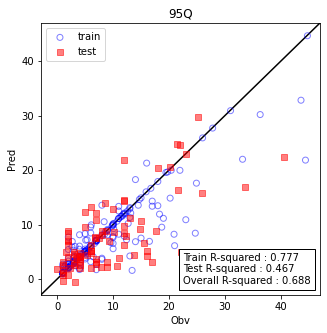

In [22]:
### 베이지안 

def svr_cv( C, gamma):

      # 모델 정의
    model = SVR(kernel = 'rbf' , C = C, gamma = gamma)
      # 모델 훈련
    model.fit(x_95q_train_scaled, y_95q_train)

      # 예측값 출력
    y_pred= model.predict(x_95q_test_scaled)
    r2 = r2_score(y_95q_test, y_pred)
    
    predict_train = model.predict(x_95q_train_scaled)
    r2_train = r2_score(y_95q_train, predict_train)
    
    if r2_train > 0.86:
        r2 = r2-0.4
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'C': (10,50 ),
           'gamma': (0.001,1) }
bo=BayesianOptimization(f=svr_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=5, n_iter=100, acq='ei', xi=0.03)
print(bo.max)

svr_model = SVR(kernel= 'rbf', C =(bo.max['params']['C']), gamma =bo.max['params']['gamma'])
score = cross_val_score(svr_model, x_95q_train_scaled, y_95q_train.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
svr_model.fit(x_95q_train_scaled, y_95q_train)
svr_predict = svr_model.predict(x_95q_test_scaled)
svr_train_predict = svr_model.predict(x_95q_train_scaled)

make_pred_obv_plot(y_95q_test,y_95q_train,svr_predict,svr_train_predict,'95Q')

0.523 test r-squared
0.847 train r-squared
5.326217812236778 test RMSE
3.120531635150683 train RMSE


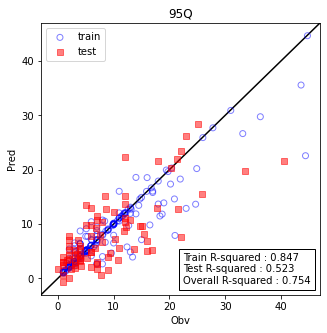

In [78]:
q_svr = SVR(kernel= 'rbf', C =38.37558349566301, gamma =0.0255926514628097)

q_svr.fit(x_95q_train_scaled, y_95q_train)
svr_predict = q_svr.predict(x_95q_test_scaled)
svr_train_predict = q_svr.predict(x_95q_train_scaled)

make_pred_obv_plot(y_95q_test,y_95q_train,svr_predict,svr_train_predict,'95Q')

In [79]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)

error_put(q_svr,x_95q_train_scaled,x_95q_test_scaled,y_95q_train,y_95q_test, q_error_train,q_error_test, q_error_total, 'SVM')

In [351]:
scaler = StandardScaler()
scaler.fit(x_95q_train)

x_95q_train_scaled = pd.DataFrame(scaler.transform(x_95q_train), columns = x_train_smote.columns)
x_95q_test_scaled = pd.DataFrame(scaler.transform(x_95q_test), columns = x_test_smote.columns)

In [262]:
q_error_train

id        RF       XGB       NGB       SVM       ANN
41   103  4.621664  5.684599  4.475680  1.045002  2.454241
562  786  1.480967  0.883528  1.122527  0.099655  0.304286
119  217  1.665547  2.950858  3.909985  0.100183 -0.026942
281  425  0.021388 -1.056540 -0.199226 -0.100072 -1.866110
523  726  1.535093  1.997796  1.860616  0.099901  1.126801
..   ...       ...       ...       ...       ...       ...
240  373  0.373606  0.810940  0.986712 -0.099912 -0.369851
42   104  7.893097  3.911778  4.350647  0.099645 -0.089372
112  203 -0.438411  0.737559 -0.442621  0.099867 -1.250242
487  679  1.331059  1.787508  1.011546  0.100189  1.303348
192  312 -1.665170 -3.830135 -3.219476 -1.072807 -3.811376

[198 rows x 6 columns]

### smote

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        | -0.008933 |  9.17     |  3.602    |
|  2        |  0.01812  |  5.001    |  1.512    |
|  3        |  0.1434   |  6.468    |  0.4618   |
|  4        |  0.0147   |  6.863    |  1.728    |
|  5        | -0.002489 |  8.968    |  2.694    |
|  6        |  0.3014   |  6.445    |  0.1605   |
|  7        |  0.51     |  6.482    |  0.03904  |
|  8        | -0.001341 |  6.493    |  3.144    |
|  9        |  0.4454   |  6.441    |  0.07264  |
|  10       |  0.4795   |  6.693    |  0.05553  |
|  11       |  0.5364   |  6.591    |  0.02274  |
|  12       |  0.1565   |  7.196    |  0.0001   |
|  13       |  0.4388   |  5.711    |  0.002116 |
|  14       |  0.5117   |  5.22     |  0.01363  |
|  15       |  0.008668 |  6.484    |  2.033    |
|  16       |  0.5042   |  5.207    |  0.0119   |
|  17       |  0.2562   |  5.362    |  0.2078   |
|  18       |  0.4721   |  6.072    |  0.006726 |


|  101      |  0.5325   |  6.619    |  0.01606  |
|  102      |  0.566    |  13.78    |  0.02019  |
|  103      |  0.5198   |  13.74    |  0.007449 |
|  104      |  0.5101   |  6.66     |  0.03928  |
|  105      |  0.5329   |  14.42    |  0.03564  |
{'target': 0.5671021269764154, 'params': {'C': 13.970935281831965, 'gamma': 0.019161998874108587}}
[0.72106246 0.69893803 0.59978699 0.4395147  0.76877284] cv - score
0.6456150023430716 cv mean - score
0.567 test r-squared
0.801 train r-squared
5.075467126045334 test RMSE
3.693453073235517 train RMSE


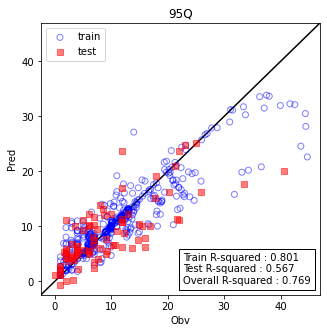

In [43]:
### 베이지안 

def svr_cv( C, gamma):

      # 모델 정의
    model = SVR(kernel = 'rbf' , C = C, gamma = gamma)
      # 모델 훈련
    model.fit(x_95q_train_scaled, y_train_smote)

      # 예측값 출력
    y_pred= model.predict(x_95q_test_scaled)
    r2 = r2_score(y_test_smote, y_pred)
    
    predict_train = model.predict(x_95q_train_scaled)
    r2_train = r2_score(y_train_smote, predict_train)
    
#     if r2_train > 0.86:
#         r2 = r2-0.4
    return r2

from bayes_opt import BayesianOptimization
import numpy as np
#n_estimators = 70, learning_rate = 0.171675, max_depth = 7, gamma = 0.0
  # 실험해보고자하는 hyperparameter 집합
pbounds = {'C': (5,15 ),
           'gamma': (0.0001,5) }
bo=BayesianOptimization(f=svr_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## verbose 2 : always, 1: max , 0: nope
## init_points : 초기 랜덤서치개수, n_iter : 반복횟수 (몇개를 확인할지 - 다다익선), acq - acquitaion function
## xi : exploration 강도
bo.maximize(init_points=5, n_iter=100, acq='ei', xi=0.01)
print(bo.max)

svr_model = SVR(kernel= 'rbf', C =(bo.max['params']['C']), gamma =bo.max['params']['gamma'])
score = cross_val_score(svr_model, x_95q_train_scaled, y_train_smote.values.ravel(), cv = KFold(n_splits=5, shuffle=True),scoring='r2')
cv_score = score.mean()
print(score,'cv - score')
print(cv_score, 'cv mean - score')
svr_model.fit(x_95q_train_scaled, y_train_smote)
svr_predict = svr_model.predict(x_95q_test_scaled)
svr_train_predict = svr_model.predict(x_95q_train_scaled)

make_pred_obv_plot(y_test_smote,y_train_smote,svr_predict,svr_train_predict,'95Q')

In [84]:
smote_svr = SVR(kernel= 'rbf',C = 13.970935281831965, gamma =0.019161998874108587)

smote_svr.fit(x_95q_train_scaled_smote, y_train_smote)
svr_predict = smote_svr.predict(x_95q_train_scaled_smote)
svr_train_predict = smote_svr.predict(x_95q_test_scaled_smote)

#make_pred_obv_plot(y_test_smote,y_train_smote,svr_predict,svr_train_predict,'Mean')

In [353]:
scaler = StandardScaler()
scaler.fit(x_train_smote)

x_95q_train_scaled_smote = pd.DataFrame(scaler.transform(x_train_smote), columns = x_train_smote.columns)
x_95q_test_scaled_smote = pd.DataFrame(scaler.transform(x_test_smote), columns = x_test_smote.columns)

In [85]:
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)

error_put(smote_svr,x_95q_train_scaled,x_95q_test_scaled,y_95q_train,y_95q_test, smote_error_train,smote_error_test, smote_error_total, 'SVM')

In [86]:
smote_error_train

id         RF       XGB       NGB       SVM
41   103  10.390720  7.243557  4.129963  9.655417
562  786   2.956411  3.229555  3.343402  5.939915
119  217   4.837001  3.789663  4.420650  4.332371
281  425  -0.468045 -0.767479 -0.622761  0.764088
523  726   2.152843  3.000296  1.598312  4.292854
..   ...        ...       ...       ...       ...
240  373   3.005691  3.553000  2.577093  0.127659
42   104   9.916376  6.408502  4.508382  2.113307
112  203   0.076214  0.838310  0.157547  2.598758
487  679   1.547169  1.801277  1.529278  3.254866
192  312  -0.983506 -1.916119 -0.340601  2.364676

[198 rows x 5 columns]

# 제주도 전체 지도 형성 (모델링 코드 X) (기존 코드 결과 정리용 코드)

In [25]:
x_train

Urban_Area  Agricultural_Area     Forest    Pasture    Barren  \
532    0.880373          23.045054   6.706370  65.095805  4.272398   
361   12.099738          77.375328   8.792651   1.496063  0.236220   
443    3.585347           1.506885  35.983372  57.313588  1.610808   
259   57.034519          32.975941   4.759414   4.864017  0.366109   
448   43.714746          54.754230   0.000000   0.443191  1.087832   
..          ...                ...        ...        ...       ...   
93     5.437597          38.037286  21.646815  34.878301  0.000000   
330   16.447167          37.519142  39.234303   6.339969  0.459418   
487    1.295001          25.977726  45.428645  26.288526  1.010101   
131   31.304348          40.676328  17.294686   9.468599  1.256039   
559    2.485759          55.230451  14.215432  26.929052  1.139306   

     Basic Rock  Sedimentary Rock  Volcanic Ash  Normal Paddy  \
532    0.000000           0.00000    100.000000      0.000000   
361    1.417234           0.00000     98.582766      0.000000   
443    0.000000           0.00000    100.000000      0.000000   
259   50.880373           0.00000     49.119627      0.000000   
448   92.147708           0.00000      7.852292      0.000000   
..          ...               ...           ...           ...   
93     0.000000           0.00000    100.000000      0.000000   
330   73.313590           0.00000     24.218493      0.000000   
487    4.105649           0.00000     95.894351      0.000000   
131   55.287009          23.26284     21.450151      3.726083   
559    0.751101           0.00000     99.248899      0.000000   

     Immatured Paddy  ...  Private Sewage Treatment  Artificial Recharge Well  \
532         0.000000  ...                         0                         0   
361         0.000000  ...                         7                         2   
443         0.000000  ...                         0                         0   
259         0.000000  ...                        13                         0   
448         0.000000  ...                        46                         2   
..               ...  ...                       ...                       ...   
93          0.000000  ...                         6                         0   
330         0.000000  ...                         0                         0   
487         0.000000  ...                         3                         0   
131         7.653575  ...                        21                         0   
559         0.000000  ...                         2                         0   

     Detention Pond  Geothermal Facility  Specified Waste Discharge Facility  \
532               0                    0                                   0   
361               0                    3                                   0   
443               0                    0                                   0   
259               0                    0                                   7   
448               0                    1                                   3   
..              ...                  ...                                 ...   
93                0                    2                                   0   
330               1                   14                                   6   
487               0                    0                                   0   
131               0                    0                                   0   
559               0                    0                                   0   

     Livestock manure Discharge Facility  Soil contamination Facility  \
532                                    0                            0   
361                                    0                            0   
443                                    2                            0   
259                                    0                            4   
448                                    0                            2   
..         

In [28]:
x_train['Forest'] - x_train['Pasture']

532   -58.389436
361     7.296588
443   -21.330216
259    -0.104603
448    -0.443191
         ...    
93    -13.231486
330    32.894334
487    19.140119
131     7.826087
559   -12.713620
Length: 308, dtype: float64

In [ ]:
# 오차 함수 설정 
def merge_train_test(error_train, error_test):
    train_test = pd.concat[error_train,error_test]

    return train_test
    
def error_func(model, x_train,x_test,y_train,y_test):
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
    
    error_train = train_pred - y_train
    error_test = train_pred - y_test
    train_test_error =  
    return error_train, error_test



def put_id(error_train, error_test, train_id, test_id,data, model_name):
    model_value = model_name + 'error'
    error_train_df = pd.DataFrame({'id':train_id, model_value: error_train })
    error_test_df = pd.DataFrame({'id':test_id, model_value: error_test })

In [112]:
def error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name):
    
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    
    train_error = train_predict - y_train
    test_error = test_predict - y_test
    
    error_train[model_name] = train_error
    error_test[model_name] = test_error
    
    error_total = pd.concat([error_train,error_test])
    
    
#    error_put(model, x_train,x_test, y_train,y_test, error_train, error_test, error_total, model_name)

In [25]:
mean_error_test = pd.DataFrame({'id':x_test_id})
mean_error_train = pd.DataFrame({'id':x_train_id})
mean_error_total = pd.concat([mean_error_test, mean_error_train])

med_error_test = pd.DataFrame({'id':x_med_test_id})
med_error_train = pd.DataFrame({'id':x_med_train_id})
med_error_total = pd.concat([med_error_test, med_error_train])

q_error_test = pd.DataFrame({'id':x_95q_test_id})
q_error_train = pd.DataFrame({'id':x_95q_train_id})
q_error_total = pd.concat([q_error_test, q_error_train])

smote_error_test = pd.DataFrame({'id':x_95q_test_id})
smote_error_train = pd.DataFrame({'id':x_95q_train_id})
smote_error_total = pd.concat([smote_error_test, smote_error_train])

In [100]:
mean_error_total = pd.concat([mean_error_test, mean_error_train])
med_error_total = pd.concat([med_error_test, med_error_train])
smote_error_total = pd.concat([smote_error_test, smote_error_train])
q_error_total = pd.concat([q_error_test, q_error_train])

In [127]:
mean_error_test.to_csv('./error/mean_error_test.csv', index=False)
mean_error_train.to_csv('./error/mean_error_train.csv', index=False)
mean_error_total.to_csv('./error/mean_error_total.csv', index=False)

med_error_test.to_csv('./error/med_error_test.csv', index=False)
med_error_train.to_csv('./error/med_error_train.csv', index=False)
med_error_total.to_csv('./error/med_error_total.csv', index=False)

q_error_test.to_csv('./error/q_error_test.csv', index=False)
q_error_train.to_csv('./error/q_error_train.csv', index=False)
q_error_total.to_csv('./error/q_error_total.csv', index=False)

smote_error_test.to_csv('./error/smote_error_test.csv', index=False)
smote_error_train.to_csv('./error/smote_error_train.csv', index=False)
smote_error_total.to_csv('./error/smote_error_total.csv', index=False)

## 제주 전체 예측

In [101]:
import pandas as pd

##불러오기
jeju = pd.read_excel('jeju_no3.xlsx')


## 필요한 열만 갖고오기
drop_col =list(jeju.columns[6:34])+list(jeju.columns[[39,44,45]])
jeju.drop(drop_col,axis=1, inplace = True)

total_jeju = jeju

## 폐기물처리, 화산회밭비, 염해논비율, 습논비율, 임지비율, 산성암비율, 하수처리장, 위생처리장, 쓰레기매립, 마을하수도, 골재채취, 염해논비율, 습논비율, 임지비율  제거
## 첫번째 열 제거

drop_cols = ['폐기물처리','화산회밭비','염해논비율',
             '습논비율','임지비율','산성암비율',
             '하수처리장','위생처리장','쓰레기매립',
             '마을하수도','골재채취']
total_jeju = total_jeju.drop(drop_cols, axis = 1)

total_jeju.columns

total_jeju.columns = ['id', 'NO3-N_sum', '95Quantile', 'Count', 'mean', 'median','Urban_Area','Agricultural_Area','Forest','Pasture','Barren','Basic Rock','Sedimentary Rock','Volcanic Ash','Normal Paddy','Immatured Paddy','Normal Field','Forest Land 2','Sandy Field','Heavy Clay Field','Forest Land 3','Private Sewage Treatment','Artificial Recharge Well','Detention Pond','Geothermal Facility','Specified Waste Discharge Facility','Livestock manure Discharge Facility','Soil contamination Facility','Wastewater Discharge Facility','Average Elevation','Index Value']#'mean_class', 'median_class', '95q_class']

In [102]:
total_jeju.dropna(subset=['Urban_Area','Agricultural_Area','Forest'], inplace =True)


In [103]:
total_jeju['id']

0       12
1       13
2       14
3       15
4       16
      ... 
594    850
595    866
596    867
597    868
598    869
Name: id, Length: 586, dtype: int64

In [113]:
total_x = total_jeju.iloc[:,6:]

In [114]:
total_x

Urban_Area  Agricultural_Area     Forest    Pasture     Barren  \
0     68.527919          27.918782   2.030457   0.507614   1.015228   
1     18.312906          75.486662   2.739726   2.559481   0.901226   
2     17.015385          65.261538   9.476923   4.153846   4.092308   
3     21.750742          58.367953   9.258160   8.278932   2.344214   
4     15.193457          82.101290   0.031456   1.855930   0.817867   
..          ...                ...        ...        ...        ...   
594   42.857143          46.031746   4.761905   1.587302   4.761905   
595   65.834933          19.961612   2.303263   6.333973   5.566219   
596   41.620112           9.217877  19.459963  25.232775   4.469274   
597    6.140351          37.719298  24.561404  31.578947   0.000000   
598    6.890130          30.540037   8.007449  36.685289  17.877095   

     Basic Rock  Sedimentary Rock  Volcanic Ash  Normal Paddy  \
0    100.000000          0.000000      0.000000      1.104972   
1     77.535965          0.000000     22.464035      0.000000   
2     64.078264          7.245491     28.676246     22.599388   
3     66.298021         18.771828     14.930151      4.918510   
4     80.107868         15.069797      4.822335      4.347826   
..          ...               ...           ...           ...   
594    0.000000          0.000000    100.000000      0.000000   
595    0.000000          0.000000    100.000000      0.000000   
596   12.487100         17.440660     36.016512      0.000000   
597    0.000000          0.000000     53.472222      0.000000   
598    0.000000          0.000000     35.657371      0.000000   

     Immatured Paddy  ...  Private Sewage Treatment  Artificial Recharge Well  \
0           0.000000  ...                         4                         0   
1           0.000000  ...                        20                         0   
2           0.703364  ...                        14                         0   
3           0.232829  ...                        31                         0   
4           0.000000  ...                        15                         0   
..               ...  ...                       ...                       ...   
594         0.000000  ...                         4                         0   
595         0.000000  ...                         6                         0   
596         0.000000  ...                        35                         0   
597         0.000000  ...                         1                         0   
598         0.000000  ...                         1                         0   

     Detention Pond  Geothermal Facility  Specified Waste Discharge Facility  \
0                 0                    0                                   0   
1                 0                    0                                   1   
2                 0                    0                                   1   
3                 0                    0                                   8   
4                 0                    0                                   0   
..              ...                  ...                                 ...   
594               0                    0                                   0   
595               0                    0                                   1   
596               0                    0                                   0   
597               0                    0                                   0   
598               0                    0                                   0   

     Livestock manure Discharge Facility  Soil contamination Facility  \
0                                      0                            0   
1                                      0                            0   
2                                      0                            0   
3                                      0                            1   
4                                      1                            0   

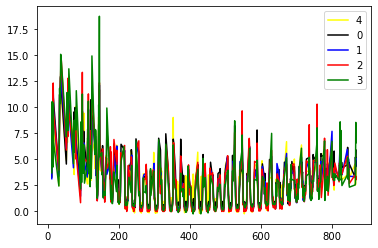

In [391]:
import matplotlib.pyplot as plt

plt.plot(total_mean_pred['id'], total_mean_pred['SVR'],label = '4', color = 'yellow')
plt.plot(total_mean_pred['id'], total_mean_pred['RF'],label = '0', color = 'black')
plt.plot(total_mean_pred['id'], total_mean_pred['XGB'],label = '1', color = 'blue')
plt.plot(total_mean_pred['id'], total_mean_pred['NGB'],label = '2', color = 'red')
plt.plot(total_mean_pred['id'], total_mean_pred['ANN'],label = '3', color = 'green')
plt.legend()


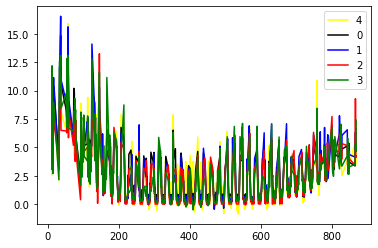

In [389]:
import matplotlib.pyplot as plt

plt.plot(total_med_pred['id'], total_med_pred['SVR'],label = '4', color = 'yellow')
plt.plot(total_med_pred['id'], total_med_pred['RF'],label = '0', color = 'black')
plt.plot(total_med_pred['id'], total_med_pred['XGB'],label = '1', color = 'blue')
plt.plot(total_med_pred['id'], total_med_pred['NGB'],label = '2', color = 'red')
plt.plot(total_med_pred['id'], total_med_pred['ANN'],label = '3', color = 'green')

plt.legend()


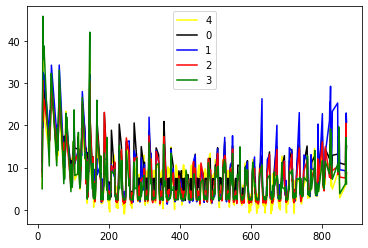

In [392]:
import matplotlib.pyplot as plt

plt.plot(total_95q_pred['id'], total_95q_pred['SVR'],label = '4', color = 'yellow')
plt.plot(total_95q_pred['id'], total_95q_pred['RF'],label = '0', color = 'black')
plt.plot(total_95q_pred['id'], total_95q_pred['XGB'],label = '1', color = 'blue')
plt.plot(total_95q_pred['id'], total_95q_pred['NGB'],label = '2', color = 'red')
plt.plot(total_95q_pred['id'], total_95q_pred['ANN'],label = '3', color = 'green')

plt.legend()


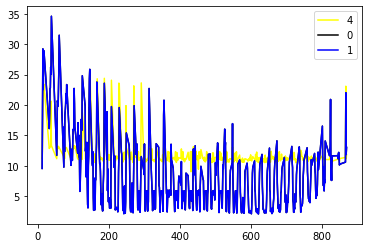

In [394]:
import matplotlib.pyplot as plt

plt.plot(total_smote_pred['id'], total_smote_pred['SVR'],label = '4', color = 'yellow')
plt.plot(total_smote_pred['id'], total_smote_pred['RF'],label = '0', color = 'black')
plt.plot(total_smote_pred['id'], total_smote_pred['XGB'],label = '1', color = 'blue')
#plt.plot(total_smote_pred['id'], total_smote_pred['NGB'],label = '2', color = 'red')
#plt.plot(total_smote_pred['id'], total_smote_pred['ANN'],label = '3', color = 'green')

plt.legend()


In [105]:
total_mean_pred = pd.DataFrame({'id':total_jeju['id']})
total_med_pred= pd.DataFrame({'id':total_jeju['id']})
total_95q_pred= pd.DataFrame({'id':total_jeju['id']})
total_smote_pred= pd.DataFrame({'id':total_jeju['id']})

In [119]:
### 베이지안 
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)
total_mean_pred['RF']=mean_rf.predict(total_x)
total_mean_pred['XGB']=np.expm1(mean_xgb.predict(total_x))
total_mean_pred['NGB']=mean_ngb.predict(total_x)
total_mean_pred['ANN']=mean_ann.predict(x_mean_total)
total_mean_pred['SVR']=mean_svr.predict(x_mean_total)

In [120]:
### 베이지안 
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)
total_med_pred['RF'] = med_rf.predict(total_x)
total_med_pred['XGB'] = med_xgb.predict(total_x)
total_med_pred['NGB'] = med_ngb.predict(total_x)
total_med_pred['ANN'] = med_ann.predict(x_med_total)
total_med_pred['SVR'] = med_svr.predict(x_med_total)


In [121]:
### 베이지안 
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)
total_95q_pred['RF'] = q_rf.predict(total_x)
total_95q_pred['XGB'] = q_xgb.predict(total_x)
total_95q_pred['NGB'] = q_ngb.predict(total_x)
total_95q_pred['ANN'] =q_ann.predict(x_95q_total)
total_95q_pred['SVR'] =q_svr.predict(x_95q_total)

In [122]:
### 베이지안 
SEED=42
import random
import os
import tensorflow as tf
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)
total_smote_pred['RF']= smote_rf.predict(total_x)
total_smote_pred['XGB']=smote_xgb.predict(total_x)
total_smote_pred['NGB']=smote_ngb.predict(total_x)
total_smote_pred['ANN']=smote_ann.predict(x_smote_total)
total_smote_pred['SVR']=smote_svr.predict(x_smote_total)


In [44]:
total_smote_pred.to_csv('smote_total_pred.csv')

In [125]:
total_mean_pred.to_csv('./total_pred/mean_total_pred.csv', index=False)
total_med_pred.to_csv('./total_pred/med_total_pred.csv', index=False)
total_95q_pred.to_csv('./total_pred/95q_total_pred.csv', index=False)
total_smote_pred.to_csv('./total_pred/smote_total_pred.csv', index=False)


In [115]:
scaler = StandardScaler()
scaler.fit(x_train)
x_mean_total = pd.DataFrame(scaler.transform(total_x), columns = x_train.columns)

In [116]:
scaler = StandardScaler()
scaler.fit(x_med_train)

x_med_total = pd.DataFrame(scaler.transform(total_x), columns = x_med_train.columns)

In [117]:
scaler = StandardScaler()
scaler.fit(x_95q_train)

x_95q_total = pd.DataFrame(scaler.transform(total_x), columns = x_95q_train.columns)

In [118]:
scaler = StandardScaler()
scaler.fit(x_train_smote)

x_smote_total = pd.DataFrame(scaler.transform(total_x), columns = x_95q_train.columns)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns = x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

scaler = StandardScaler()
scaler.fit(x_med_train)

x_med_train_scaled = pd.DataFrame(scaler.transform(x_med_train), columns = x_med_train.columns)
x_med_test_scaled = pd.DataFrame(scaler.transform(x_med_test), columns = x_med_test.columns)

scaler = StandardScaler()
scaler.fit(x_95q_train)

x_95q_train_scaled = pd.DataFrame(scaler.transform(x_95q_train), columns = x_95q_train.columns)
x_95q_test_scaled = pd.DataFrame(scaler.transform(x_95q_test), columns = x_95q_test.columns)